In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from settings import DATA_DIR, MODEL_DIR
from src.utils import transform

# Load data into memory

In [2]:
file = os.path.join(DATA_DIR, 'era5_west_pacific_sst.nc')
ds = xr.open_dataset(file)
arr = ds['sst'].mean(dim='expver')[:, ::2, ::2]  # Half resolution
ds.close()

Text(0, 0.5, 'lat')

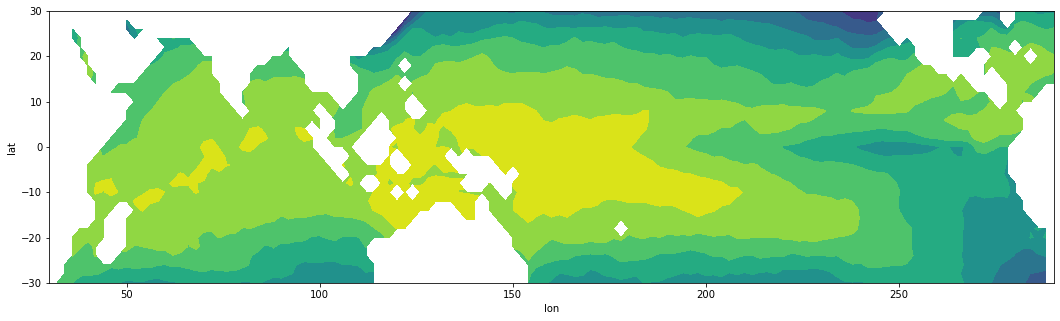

In [3]:
plt.figure(figsize=[18, 5])
plt.contourf(arr.coords['longitude'], arr.coords['latitude'], arr[0, :, :])
plt.xlabel('lon')
plt.ylabel('lat')

# Seasonality and trend removal

In [4]:
doy = arr.coords['time'].dt.dayofyear

# Calculate seasonal mean
means = arr.groupby(doy).mean()

test = means.isel(longitude=12, latitude=12)

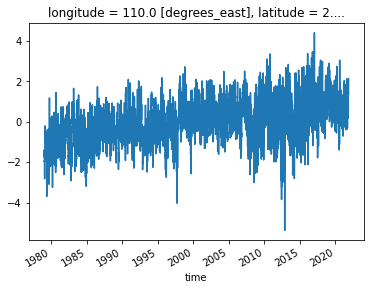

In [5]:
rem_seas = transform.SeasonalityRemoverFFT(div_std=True, fft_keep_frac=0.03).fit(arr)
deseas = rem_seas.transform(arr)

i, j = 14, 40
deseas[:, i, j].plot()

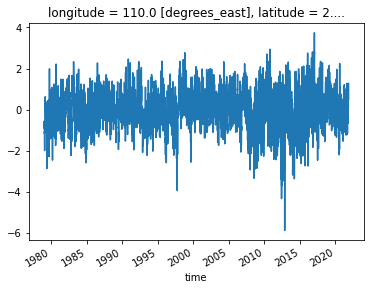

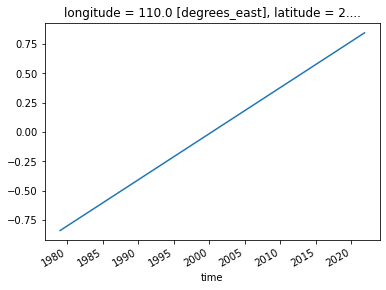

In [6]:
rem_trend = transform.TrendRemover().fit(deseas)
detr = rem_trend.transform(deseas)

detr[:, i, j].plot()
plt.show()
(deseas - detr)[:, i, j].plot()
plt.show()

Text(0, 0.5, 'lat')

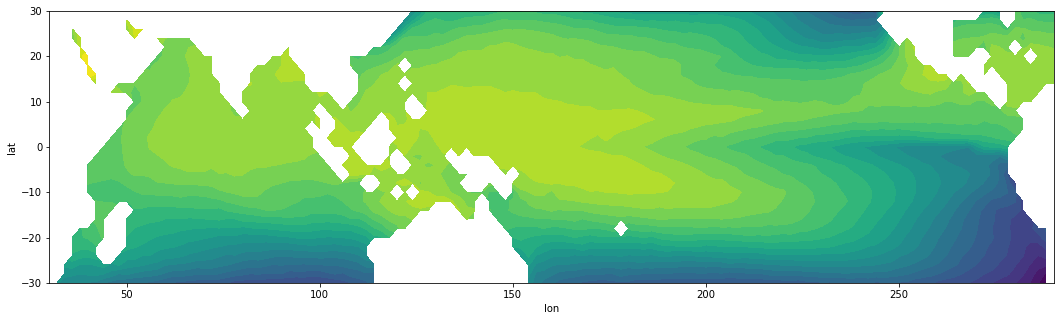

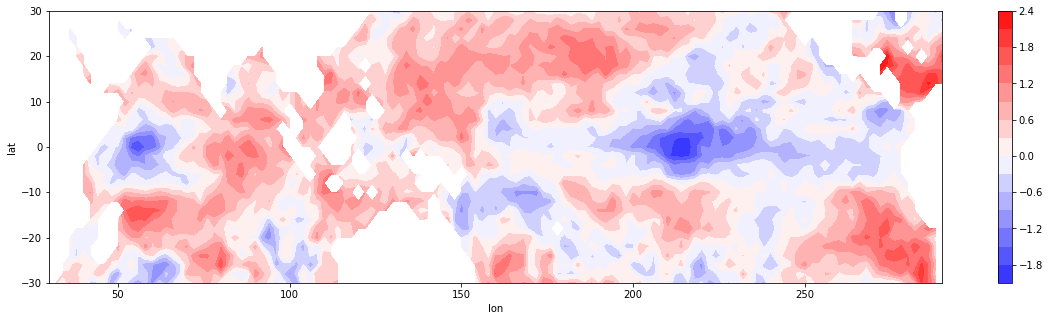

In [7]:
plt.figure(figsize=[18, 5])
plt.contourf(
    deseas.coords['longitude'],
    deseas.coords['latitude'], 
    rem_seas.get_means().sel(dayofyear=deseas.coords['time'].dayofyear)[300, :, :], 
    cmap='viridis', levels=25
)
plt.xlabel('lon')
plt.ylabel('lat')

plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr.coords['longitude'], 
    detr.coords['latitude'], 
    detr[850: 880, :, :].mean(axis=0),
    cmap='bwr', vmin=-2.5, vmax=2.5, levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')

# PCA

We'll need to flatten all the arrays and get rid of NaNs. We want to do this in such a way that we can easily transform back into the grid shape (for visualization). 

Text(0, 0.5, 'lat')

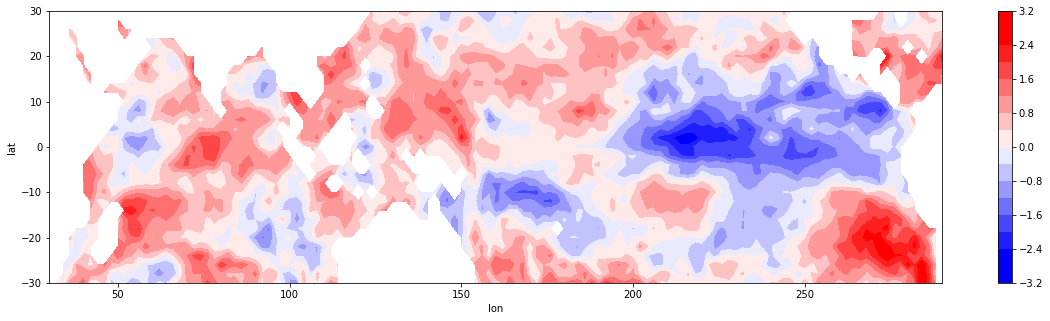

In [8]:
df_tfm = transform.DataArray2DataFrame().fit(detr)
df_detr = df_tfm.transform(detr).dropna(how='all', axis=1)

detr_copy = df_tfm.inverse_transform(df_detr)   
plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr_copy.coords['longitude'], 
    detr_copy.coords['latitude'],
    detr_copy[850:855, :, :].mean(axis=0), 
    cmap='bwr', vmin=-2.5, vmax=2.5, levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')

In [9]:
df_detr.head()

latitude        30.0                                                    \
longitude      50.0      124.0     126.0     128.0     130.0     132.0   
time                                                                     
1979-01-01 -0.392969  0.279440  0.730788  0.326178  0.219560  0.172657   
1979-01-02 -0.638078  0.299285  0.815419  0.440264  0.567269  0.523459   
1979-01-03 -0.678214  0.397494  0.914424  0.595247  0.960295  0.875372   
1979-01-04 -0.544152  0.527148  0.930099  0.681902  1.242972  1.074743   
1979-01-05 -0.225924  0.663333  0.840633  0.657846  1.316089  1.068116   

latitude                                            ...     -30.0            \
longitude      134.0     136.0     138.0     140.0  ...     270.0     272.0   
time                                                ...                       
1979-01-01  0.475407  0.697009  0.177223  0.141300  ...  1.165471  0.824964   
1979-01-02  0.648046  0.773619  0.362446  0.175204  ...  1.108711  0.800777   
1979-01-03  0.799490  0.874053  0.560307  0.177001  ...  1.057272  0.783833   
1979-01-04  0.840849  0.918203  0.613436  0.066172  ...  1.081691  0.834349   
1979-01-05  0.752363  0.873048  0.493687 -0.128660  ...  1.161313  0.926738   

latitude                                                                \
longitude      274.0     276.0     278.0     280.0     282.0     284.0   
time                                                                     
1979-01-01  0.780439  0.607593  0.567519  0.353245  0.311546 -0.375221   
1979-01-02  0.752630  0.550076  0.451188  0.186749  0.110200 -0.603251   
1979-01-03  0.734077  0.537985  0.389410  0.096144 -0.028750 -0.701860   
1979-01-04  0.792334  0.627968  0.464119  0.174976  0.006710 -0.596313   
1979-01-05  0.900558  0.777857  0.626352  0.355510  0.166134 -0.381909   

latitude                        
longitude      286.0     288.0  
time                            
1979-01-01  0.065605  0.095956  
1979-01-02 -0.181584 -0.198547  
1979-01-03 -0.264058 -0.356075  
1979-01-04 -0.105776 -0.287474  
1979-01-05  0.179181 -0.062628  

[5 rows x 3303 columns]

## Reduce the dimensionalities

In [197]:
from sklearn.decomposition import PCA

class PCADF(PCA): 

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame: 
        df = pd.DataFrame(
            index=X.index, 
            columns=pd.RangeIndex(0, n_components, name='eof'), 
            data=super().transform(X.values)
        )
        self.cols = X.columns
        return df

    def inverse_transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame: 
        df = pd.DataFrame(
            index=X.index, 
            columns=self.cols, 
            data=super().inverse_transform(X.values)
        )
        return df



df_monthly = df_detr.resample('MS').mean()

n_components = 15
pca = PCADF(n_components=n_components).fit(df_monthly)
df_decomp = pca.transform(df_monthly)

df_decomp.head()

/opt/anaconda3/envs/sst_model/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


eof,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
time,,,,,,,,,,,,,,,
1979-01-01,7.363568,-1.627305,-9.847473,-0.485361,-6.209109,8.899305,2.758003,-8.157728,-13.381588,4.549064,-1.346895,4.767884,3.618223,5.512464,1.130549
1979-02-01,-1.163639,2.750535,-15.201726,-4.653710,-17.293077,2.207839,0.547645,-4.083052,-10.699446,0.084920,-7.772638,-4.124282,4.658780,2.364468,0.479990
1979-03-01,-6.676830,1.004456,-12.881960,-9.718206,-9.751293,6.435503,-4.815092,-3.356914,-0.048482,3.761461,-7.106995,-1.962970,3.022888,3.435468,2.160296
1979-04-01,4.765279,0.691830,-8.220480,-6.441576,-8.616451,1.916578,6.068803,-3.602205,-1.210142,1.327548,-13.087387,-2.833860,1.151662,5.117959,1.656036
1979-05-01,5.841064,2.862588,-0.850946,-0.402733,-8.204393,-3.026459,8.041796,-2.956211,-2.146183,8.651276,-15.648980,5.808251,0.002414,4.189419,-1.812933


In [198]:
np.cumsum(pca.explained_variance_ratio_)

array([0.22645548, 0.31073228, 0.3659142 , 0.41280096, 0.45008839,
       0.48088498, 0.50693378, 0.52869017, 0.54951424, 0.56759679,
       0.58457887, 0.6006532 , 0.6138646 , 0.62677543, 0.63957903])

## Build the LIM

In [353]:
from ipaddress import v4_int_to_packed
from scipy.linalg import inv, logm, expm, eigh, eig, pinv, svd


def covariance_with_nans(x1: np.ndarray, x2: np.ndarray) -> np.ndarray: 
    """Calculate covariance matrix with NaNs weighted as 0.

    Args:
        x1 (np.ndarray): Data array, shape (n_records, n_features)
        x2 (np.ndarray): Data array, shape (n_records, n_features)

    Returns:
        np.ndarray: Covariance matrix. 
    """
    
    # Weights determined by where matrices are NaN
    w1 = np.logical_not(np.isnan(x1)).astype('float64')
    w2 = np.logical_not(np.isnan(x2)).astype('float64')

    # Calculate covariance
    covar = ((x1 * w1).T @ (x2 * w2)) / (w1.T @ w2)

    # Fill entries where w.T @ w is NaN (no weight and no sum) or inf (sum and zero weight).
    covar[np.isinf(covar) | np.isnan(covar)] = 0.  

    return covar


def lag_covariance_with_nans(x: np.ndarray, lag: int = 0) -> np.ndarray: 
    """Calculate lag covariance matrix with NaNs weighted as 0.

    Args:
        x (np.ndarray): Data array, shape (n_records, n_features)
        lag (ing): Lag for covariance matrix, in number of records. Defaults to 1.

    Returns:
        np.ndarray: Weighted lag covariance
    """
    if not lag: 
        return covariance_with_nans(x1=x, x2=x)
    else: 
        return covariance_with_nans(x1=x[lag:, :], x2=x[:-lag, :])


def check_lim_conditions(X: np.ndarray) -> None:

    # 1. System is gaussian

    # 2. B has eigenvalues with negative real parts

    # 3. Q is positive definite

    # 4. The forecasts are good

    # 5. The forecast errors grow as predicted

    # 6. B is independent of step_size

    return  


class LIM: 

    def __init__(self):
        """Impliments a Linear Inverse Model following 
        Penland and Sardeshmukh (1995), Penland and Matrosova (1994), 
        and Perkins and Hakim (2019). 
        """
        self.fit_periods = None
        self.covar = None
        self.covar_lag = None
        self.B = None
        self.G = None
        self.Q = None
        self.Q_eig = None

    def fit(self, X: np.ndarray, fit_periods: int = 1): 
        """Fit LIM. Described in Section 2. 

        Args:
            X (np.ndarray): Array of shape (n_steps, n_points), 
                used to train the LIM. Rows are instances, which must be 
                available at evenly spaced intervals. 
            n_steps (int, optional): Number of data periods (lag) used for training. 
                Defaults to 1.

        Returns:
            self
        """

        # Save step size of integration
        self.fit_periods = fit_periods

        # Calculate B, propagation matrix
        self.covar = lag_covariance_with_nans(X, lag=0)
        self.covar_lag = lag_covariance_with_nans(X, lag=self.fit_periods)
        self.G = self.covar_lag @ inv(self.covar)
        self.B = logm(self.G) / self.fit_periods  # L in Perkins and Hakim

        # Calculate Q, noise matrix
        self.Q = -(self.B @ self.covar + self.covar @ self.B.T)

        # Calc noise EOFs (EOFs of Q), to be used for generating 
        # spatially correlated white noise. 
        val, vec = eigh(self.Q)
        self.Q_eig = {
            'val': val,  # Ascending order
            'vec': vec,
        }

        return self

    def _predict_deterministic(self, X: np.ndarray, lag: int = 1) -> np.ndarray:

        G = expm(self.B * lag)
        if X.ndim == 1: 
            return G @ X
        else: 
            return X @ G.T  # G is symmetric. 

    def _calc_error_covar_matrix(self, lag: int = 1) -> np.ndarray: 
        """Calculate error covariance matrix, which is used to 
        normalize predictions. This is Penland and Sardeshmukh (1995) Eqn 7.

        Args:
            lag (int, optional): Lag for error matrix, in data periods. Defaults to 1.

        Returns:
            np.ndarray: Matrix for calculating expected errors. 
        """

        G_lag = expm(self.B * lag)
        E = self.covar - (G_lag @ self.covar @ G_lag.T) 

        return E.real

    def simulate(self, x0: np.ndarray, sim_periods: int = 12, 
                 with_noise: bool = True, steps_per_period = 240) -> np.ndarray: 
        """Run simulation for sim_periods data periods. Return array with results. 

        Args:
            x0 (np.ndarray): Initial state vector
            sim_periods (int, optional): Number of data periods to integrate forward. 
                Defaults to 12.
            with_noise (bool, optional): Include spatially correlated white noise 
                in integration if True. Defaults to True.
            steps_per_period (int, optional): Number of intermediate time steps 
                per data period. Recommended to be high relative to the 
                periods of variability in the system. Only used when 
                with_noise=True. Defaults to 240.  

        Returns:
            np.ndarray: State vector through simulation, shape (sim_periods, n_features)
        """

        # Integrate forward for sim_periods, 
        # saving results in (n_dim, n_steps + 1) array. 
        out_arr = np.zeros((sim_periods + 1, x0.shape[0]))
        out_arr[0, :] = x0

        if with_noise: 

            # Handle timestep
            total_steps = sim_periods * steps_per_period
            dt = 1. / steps_per_period

            # Initialize state vector for start of simulation (at t = -dt / 2). 
            # Assume X(-dt/2) = X(0). Introduces small error. 
            x_half = np.copy(x0)
            x_1 = np.copy(x_half)  
            
            for i in range(total_steps): 

                # Integrate forward to t = t + dt / 2

                # Calculate noise piece. Ignore negative noise eigenvalues, 
                # which suggest non-linearity or small sample size (Penland and Matrosova 1994)
                rand = np.random.normal(0, 1, size=(self.Q_eig['val'].shape[0],))
                noise = self.Q_eig['vec'] @ np.sqrt(np.maximum(self.Q_eig['val'], 0.) * dt) * rand
                
                # Calculate deterministic piece
                determ = (self.B * dt) @ x_1

                # Perform integration
                x_2 = x_1 + noise + determ

                # X(t) = (X(t - dt / 2) + X(t + dt / 2)) / 2
                x_half = (x_1 + x_2) / 2

                # Save if t corresponds to an output time. 
                if i % steps_per_period == 0 and i > 0: 
                    out_arr[i // steps_per_period, :] = x_half

                x_1 = x_2

        else: 

            # Following Eqn 6 of Penland and Sardeshmukh (1995). 
            out_arr[0, :] = np.copy(x0)
            for i in range(sim_periods): 
                out_arr[i + 1, :] = self._predict_deterministic(x0, lag=i + 1)

        return out_arr

    def predict_expected_spatial_skill_(self, x0: np.ndarray, lag: int = 1) -> np.ndarray: 
        """Expected skill of a LIM forecast given an initial 
        state vector and lag. 

        Args:
            x0 (np.ndarray): Initial state vector
            lag (int, optional): Forecast lag in data periods. Defaults to 1.

        Returns:
            np.ndarray: Vector of expected skills, shape (n_features,).                 
        """

        # Make predictions given initial state
        X_hat = self._predict_deterministic(X=x0, lag=lag)

        # Covariance is just magnitude of predictions for each feature.
        # (because only one instance). 
        F = X_hat ** 2

        # Calculate 
        E = self._calc_error_covar_matrix(lag=lag)
        snr = F / np.diagonal(E)

        # Calc expected skill and save. 
        skill = (snr ** 2) / (((snr ** 2 + 1) * (snr ** 2)) ** 0.5)

        return skill

    def calc_expected_time_avg_spatial_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray: 
        """Calculate the time-averaged expected skill, for all points in the 
        state vector, at a given lag. Following Newman et al (2003) 
        Eqns 7 and 8. Basically reproducing Section 5a. 

        Args:
            X (np.ndarray): Array of system observations with shape 
                (n_records, n_features). 
            lag (int, optional): Forecast lag in data periods. Defaults to 1.

        Returns:
            np.ndarray: 1d vector of average expected skills in predicting
                each feature, shape (n_features,). 
        """

        # Calcualte SNR 
        X_hat = self._predict_deterministic(X, lag=lag)
        F = covariance_with_nans(X_hat, X_hat)  # This averages implicitly across time. 
        E = self._calc_error_covar_matrix(lag=lag)
        snr = np.diagonal(F) / np.diagonal(E)

        # Calculate expected skill
        rho_inf = (snr ** 2) / (((snr ** 2 + 1) * (snr ** 2)) ** 0.5)

        return rho_inf


    def calc_real_time_avg_spatial_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray: 
        """Calculate the time-averaged real skill, for all points in the 
        state vector, at a given lag. Following Newman et al (2003) 
        Eqns 6.

        Args:
            X (np.ndarray): Array of system states with shape 
                (n_records, n_features). Must be in order of their observation
                without gaps. 
            lag (int, optional): Forecast lag in data periods. Defaults to 1.

        Returns:
            np.ndarray: 1d vector of average real skills in predicting
                each feature, shape (n_features,). 
        """

        # Calculate average error, following Newman et al (2003) Eqn 6. 
        # Covariance implicitly takes time avg. 
        X_hat = self._predict_deterministic(X[:-lag, :], lag=lag)
        truth = X[lag:, :]
        numer = np.diagonal(covariance_with_nans(X_hat, truth))  
        denom = (
            np.diagonal(covariance_with_nans(X_hat, X_hat)) * 
            np.diagonal(covariance_with_nans(truth, truth))
        ) ** 0.5
        skill = numer / denom

        return skill

    def calc_expected_spatial_avg_time_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray: 
        """Gives spatial avg skill as a function of time. Basically a vectorized version of 
        predict_expected_spatial_skill, with a spatial average at the end. 

        Args:
            X (np.ndarray): Array of initial conditions, shape (n_records, n_features). 
            lag (int, optional): Forecast lag in data periods. Defaults to 1.

        Returns:
            np.ndarray: Vector of spatially averaged skill as f(time), shape (n_periods,).
        """

        # Make predictions
        X_hat = self._predict_deterministic(X, lag=lag)

        # Sum of squared magnitudes of predictions 
        # (trace of sample-size 1 covariance). 
        F = (X_hat ** 2).sum(axis=1)

        # Calculate signal to noise ratio
        E = self._calc_error_covar_matrix(lag=lag)
        snr = F / np.trace(E)

        # Calculate expected skill
        skill = (snr ** 2) / (((snr ** 2 + 1) * (snr ** 2)) ** 0.5)

        return skill

    def calc_real_spatial_avg_time_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray: 
        """Gives spatially averaged real skill as a function of time. 
        Basically adapted calc_real_time_avg_spatial_skill so that averaging is 
        across space instead of time. 

        Args:
            X (np.ndarray): Array of initial states. 
            lag (int, optional): Forecast lag in data periods. Defaults to 1.

        Returns:
            np.ndarray: Vector of skills with shape (n_periods - lag,).
        """

        # Calculate average error. 
        X_hat = self._predict_deterministic(X[:-lag, :], lag=lag)
        truth = X[lag:, :]
        numer = (X_hat * truth).sum(axis=1)
        denom = ((X_hat ** 2).sum(axis=1) * (truth ** 2).sum(axis=1)) ** 0.5
        skill = numer / denom

        return skill

    def calc_maximally_amplifying_structures_(self, lag: int = 1) -> tuple: 
        """Calculate maximally amplifying spatial structures. 
        This follows Newman et al (2003) section 5c. 

        Args:
            lag (int, optional): Forecast lag in data periods, for which 
                maximally amplifying structures will be calculated. 
                Defaults to 1.

        Returns:
            tuple: Contains arrays of structures and corresponding 
                expected predictability. Both have shape (n_features, n_features). 
                The array of structures has the structures in rows; the array 
                of predictabilities has spatial predictabilities in rows. 
        """

        # SVD of lagged G
        G_lag = expm(self.B * lag)
        u, s, v = svd(G_lag)  # singular values sorted in non-increasing order
        
        # Calculate structures and corresponding predictability
        structs = np.zeros(shape=G_lag.shape)  # G is square
        predictability = np.zeros(shape=G_lag.shape)
        for i, s_i in enumerate(s):
            struct = v[:, i].real
            structs[i, :] = struct
            alpha_i = (np.trace(self.covar) ** 0.5) / s_i
            predictability[i, :] = self.predict_expected_spatial_skill_(alpha_i * struct)
             
        return structs, predictability

    def calc_corr_with_maximally_amplifying_structures(self, x0: np.ndarray, lag: int = 1) -> np.ndarray:
        """Calculate correlation of some initial state with 
        the various maximally amplifying structures. 

        Args:
            x0 (np.ndarray): Initial state, vector with shape (n_features,)
            lag (int, optional): Forecast lag in data periods used to 
                calculate structures. Defaults to 1.

        Returns:
            np.ndarray: Vector of correlations with structures, shape (n_features,). 
        """

        structs, _ = self.calc_maximally_amplifying_structures_(lag=lag)
        covars = structs @ x0  # Calculation of spatial correlation wrong? 
        corrs = covars / (np.std(structs, axis=1) * np.std(x0))

        return corrs
    

class PCALIM(LIM): 

    def __init__(self, n_components: int = 15): 
        self.n_components = 15
        self.pca = PCA(n_components=n_components)
        super().__init__()
    
    def fit(self, X: np.ndarray, fit_periods: int = 1): 
        self.pca.fit(X)
        tfm = self.pca.transform(X)
        super().fit(tfm, fit_periods=fit_periods)

    def simulate(self, x0: np.ndarray, sim_periods: int = 12, 
                 with_noise: bool = True, steps_per_period = 240) -> pd.DataFrame: 
        x0_tfm = self.pca.transform(x0.reshape(1, -1))
        sim = super().simulate(
            x0_tfm.ravel(), sim_periods=sim_periods, 
            with_noise=with_noise, steps_per_period=steps_per_period
        )
        sim_itfm = self.pca.inverse_transform(sim)
        return sim_itfm

    def predict_expected_spatial_skill_sub(self, x0: np.ndarray, lag: int = 1) -> np.ndarray:
        x0_tfm = self.pca.transform(x0.reshape(1, -1))
        skill = super().predict_expected_spatial_skill(x0_tfm, lag)
        skill_itfm = self.pca.inverse_transform(skill.reshape(1, -1))
        return skill_itfm

    def calc_expected_time_avg_spatial_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray:
        X_tfm = self.pca.transform(X)
        skill = super().calc_expected_time_avg_spatial_skill(X_tfm, lag)
        skill_itfm = self.pca.inverse_transform(skill.reshape(1, -1)).ravel()
        return skill_itfm

    def calc_real_time_avg_spatial_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray:
        X_tfm = self.pca.transform(X)
        skill = super().calc_real_time_avg_spatial_skill(X_tfm, lag)
        skill_itfm = self.pca.inverse_transform(skill.reshape(1, -1)).ravel()
        return skill_itfm

    def calc_expected_spatial_avg_time_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray:
        X_tfm = self.pca.transform(X)
        skill = super().calc_expected_spatial_avg_time_skill(X_tfm, lag)
        return skill

    def calc_real_spatial_avg_time_skill(self, X: np.ndarray, lag: int = 1) -> np.ndarray:
        X_tfm = self.pca.transform(X)
        skill = super().calc_real_spatial_avg_time_skill(X_tfm, lag)
        return skill

    def calc_maximally_amplifying_structures(self, lag: int = 1) -> tuple:
        structs, predictability =  super().calc_maximally_amplifying_structures_(lag=lag)
        structs_itfm = self.pca.inverse_transform(structs)
        predictability_itfm = self.pca.inverse_transform(predictability)
        return structs_itfm, predictability_itfm

    def calc_corr_with_maximally_amplifying_structures(self, x0: np.ndarray, lag: int = 1) -> np.ndarray:
        x0_tfm = self.pca.transform(x0.reshape(1, -1)).ravel()
        corr = super().calc_corr_with_maximally_amplifying_structures(x0_tfm, lag)
        return corr


In [354]:
pcalim = PCALIM(n_components=15)
pcalim.fit(df_monthly.values, fit_periods=7)

pcalim.calc_corr_with_maximally_amplifying_structures(x0=df_monthly.iloc[218].values.ravel(), lag=7)

/var/folders/dq/7sw_cxq97gjg6xd_0d3phv_00000gn/T/ipykernel_4544/2463296572.py:366: ComplexWarning: Casting complex values to real discards the imaginary part
  predictability[i, :] = self.predict_expected_spatial_skill_(alpha_i * struct)


array([ 4.26451142,  5.92018607, -5.29609794, -3.95140076, -6.76755006,
        5.57139637,  3.3490322 , -0.74483592,  1.33680395,  1.53980812,
       -0.28480815, -1.83127009,  3.35526223,  1.95831852, -5.1469312 ])

/var/folders/dq/7sw_cxq97gjg6xd_0d3phv_00000gn/T/ipykernel_4544/1883790727.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  out_arr[i // steps_per_period, :] = x_half


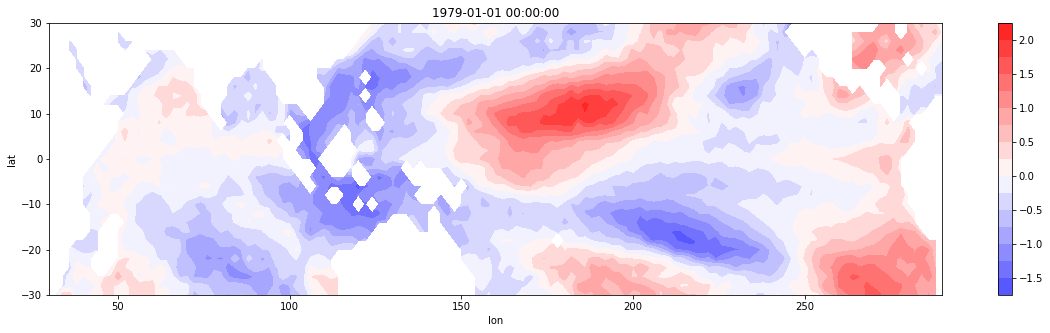

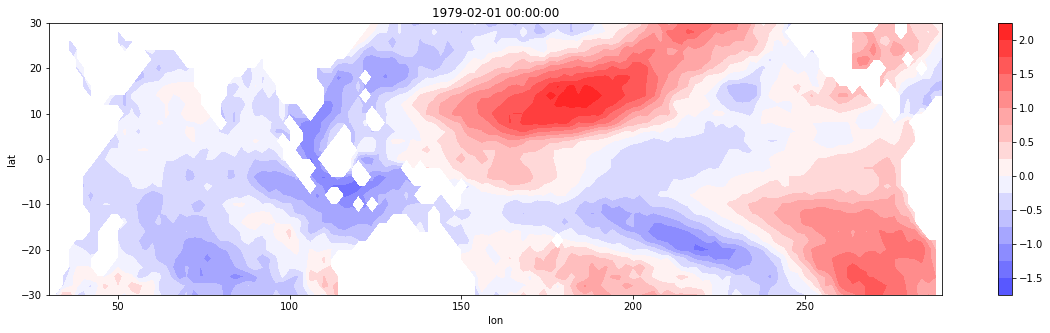

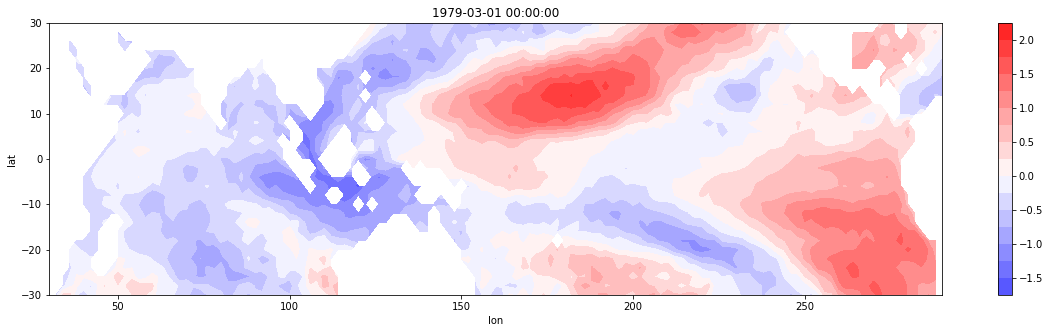

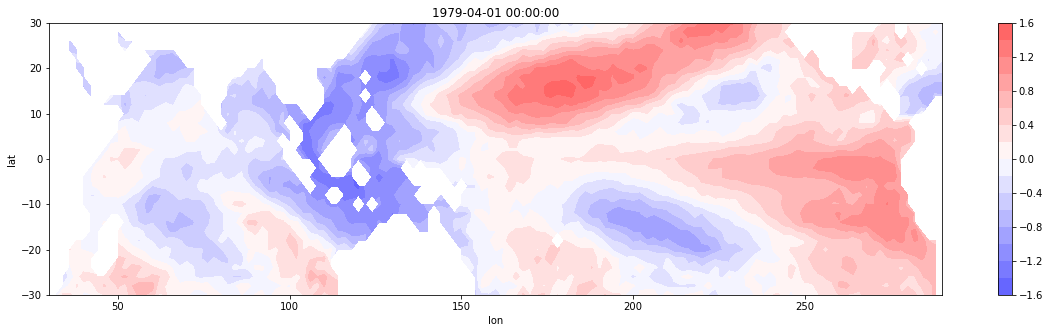

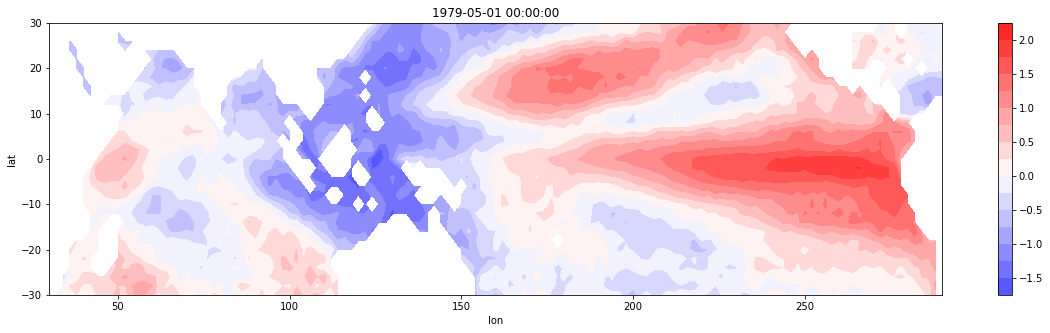

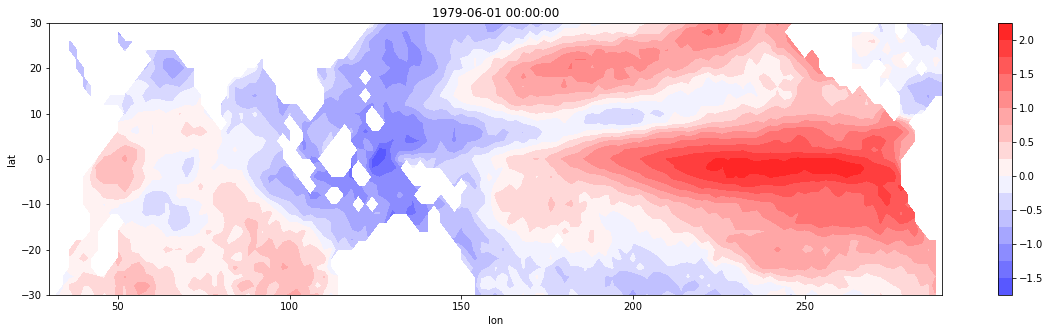

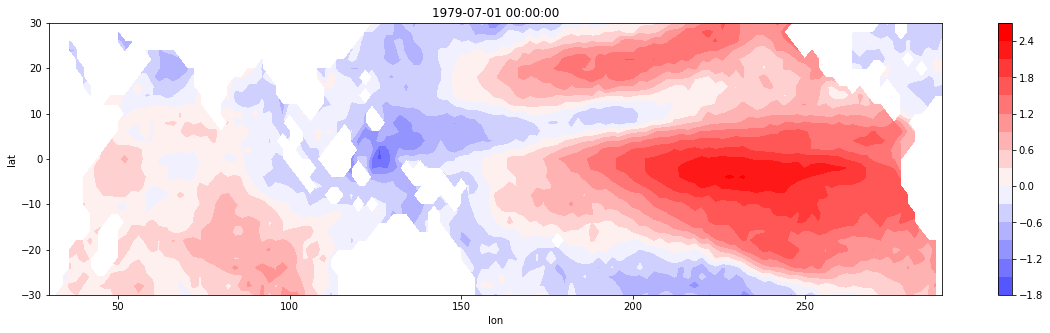

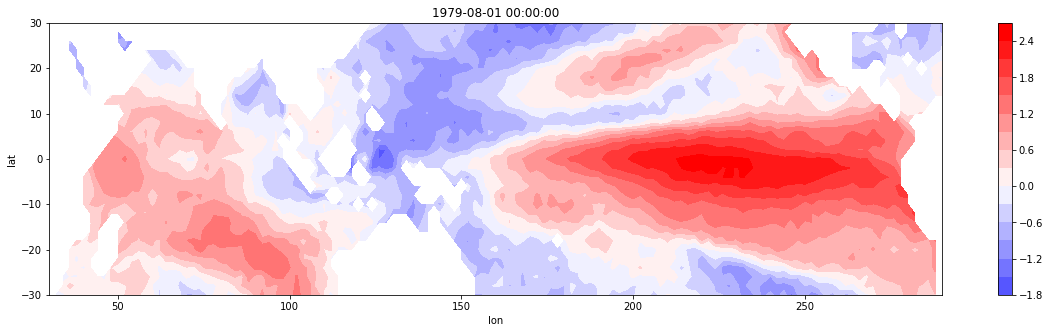

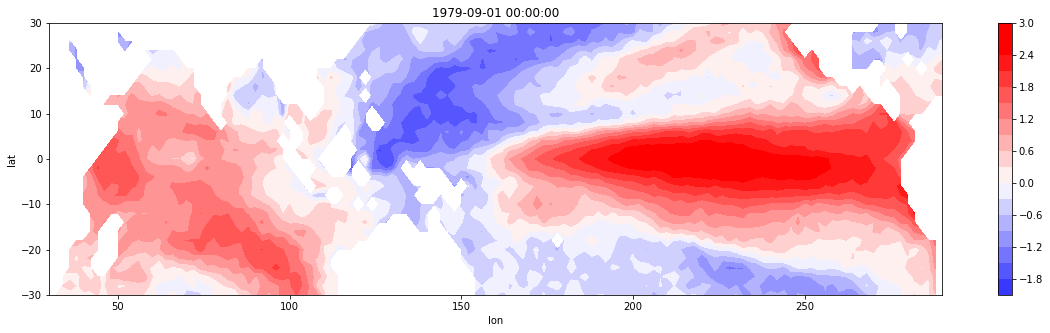

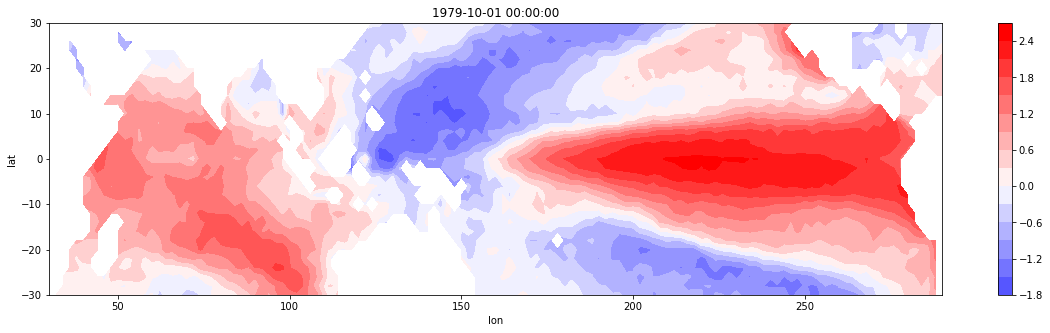

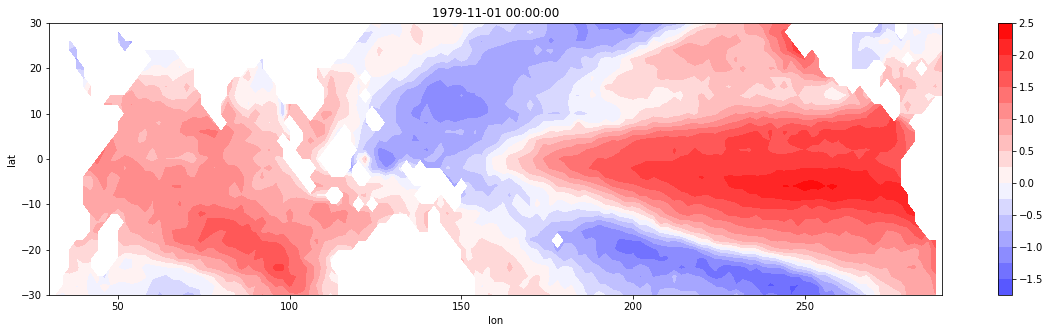

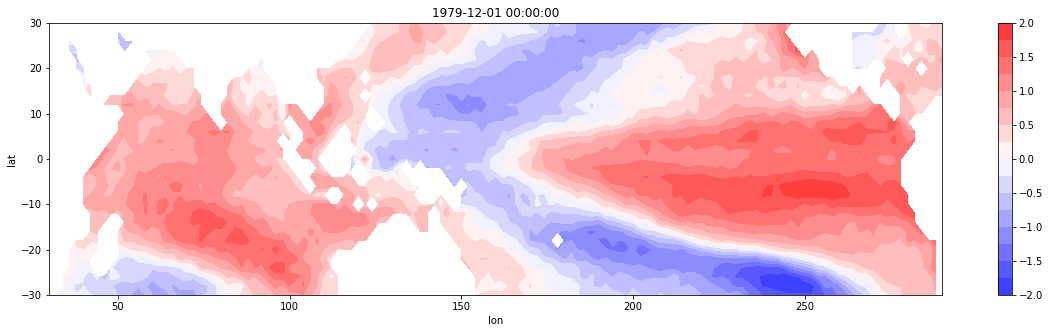

latitude        30.0                                                    \
longitude      50.0      124.0     126.0     128.0     130.0     132.0   
time                                                                     
1979-01-01 -0.372953 -0.020808 -0.078081 -0.299669 -0.524739 -0.232090   
1979-02-01 -0.397959  0.182049 -0.027253 -0.114186 -0.401219 -0.236393   
1979-03-01 -0.446468  0.154383 -0.123011 -0.185321 -0.501801 -0.385438   
1979-04-01 -0.355031 -0.195846 -0.494685 -0.602689 -0.833579 -0.748157   
1979-05-01 -0.452927 -0.159904 -0.630152 -0.841136 -1.031869 -1.003358   

latitude                                            ...     -30.0            \
longitude      134.0     136.0     138.0     140.0  ...     270.0     272.0   
time                                                ...                       
1979-01-01 -0.407271 -0.487389 -0.253101 -0.352863  ...  1.600209  1.519254   
1979-02-01 -0.409656 -0.648574 -0.507637 -0.492883  ...  1.591974  1.520680   
1979-03-01 -0.529271 -0.801196 -0.679421 -0.651365  ...  1.483364  1.516114   
1979-04-01 -0.915118 -1.067809 -0.932279 -0.794476  ...  0.470326  0.569938   
1979-05-01 -1.040896 -1.215205 -1.127602 -0.905208  ... -0.058919  0.244884   

latitude                                                                \
longitude      274.0     276.0     278.0     280.0     282.0     284.0   
time                                                                     
1979-01-01  1.314343  1.346193  1.186877  1.157611  1.133784  0.790556   
1979-02-01  1.442681  1.395672  1.342132  1.231177  1.086889  0.849796   
1979-03-01  1.432909  1.409099  1.342972  1.222223  1.083494  0.847521   
1979-04-01  0.495018  0.400157  0.404198  0.424131  0.425466  0.298723   
1979-05-01  0.126163  0.165356  0.139709  0.207323  0.252425  0.100962   

latitude                        
longitude      286.0     288.0  
time                            
1979-01-01  1.008630  0.828837  
1979-02-01  1.001033  0.795146  
1979-03-01  1.005170  0.829510  
1979-04-01  0.501144  0.671441  
1979-05-01  0.339901  0.644987  

[5 rows x 3303 columns]

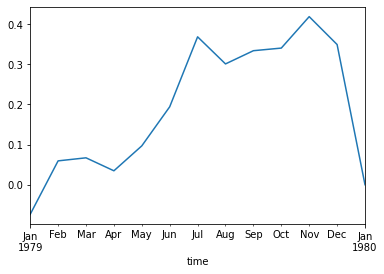

In [293]:
sim = pd.DataFrame(
    data=pcalim.simulate(df_monthly.iloc[218].values, sim_periods=12, with_noise=True, steps_per_period=240), 
    columns=df_monthly.columns, 
    index=df_monthly.index[:13]
)

detr_copy = df_tfm.inverse_transform(sim)

for i, t in enumerate(sim.index[:12]): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        detr_copy.coords['longitude'], 
        detr_copy.coords['latitude'],
        detr_copy[i, :, :], 
        cmap='bwr', vmin=-2.5, vmax=2.5, levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(t)
    plt.show()

sim.mean(axis=1).plot()

sim.head()


/opt/anaconda3/envs/sst_model/lib/python3.9/site-packages/xarray/core/common.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self.values, dtype=dtype)


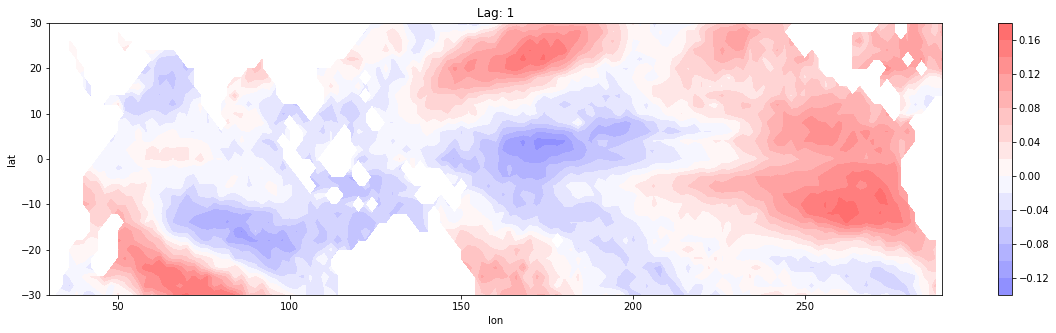

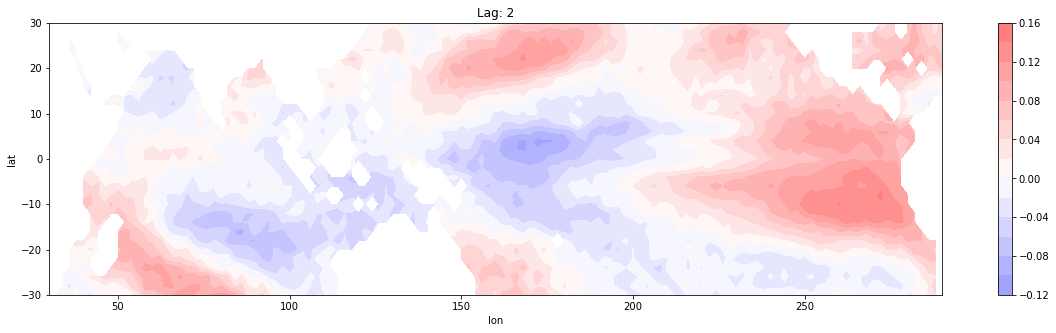

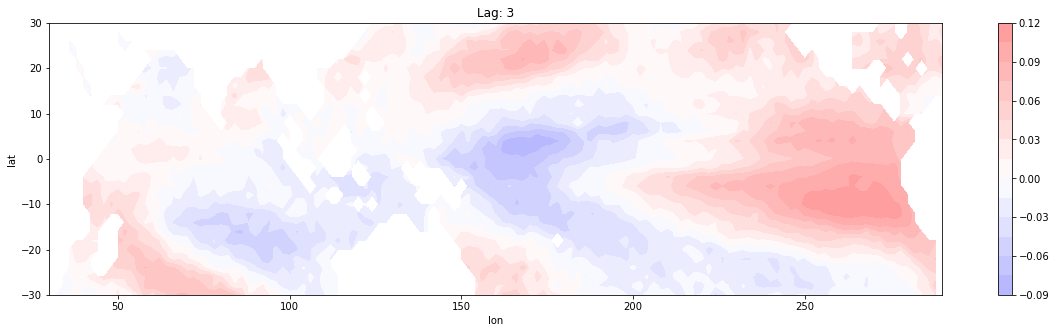

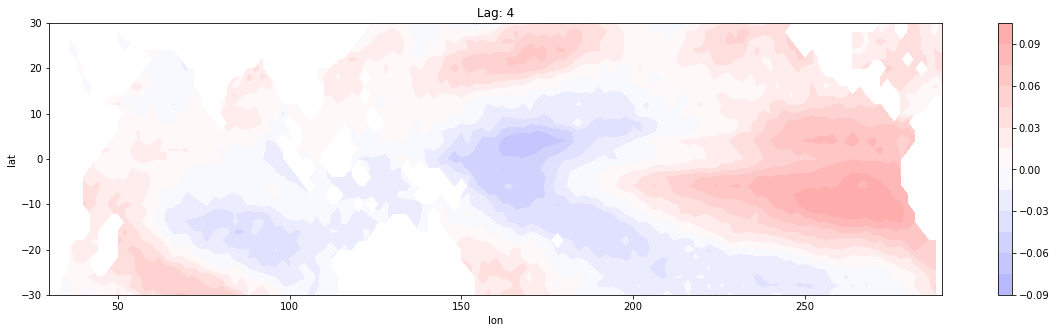

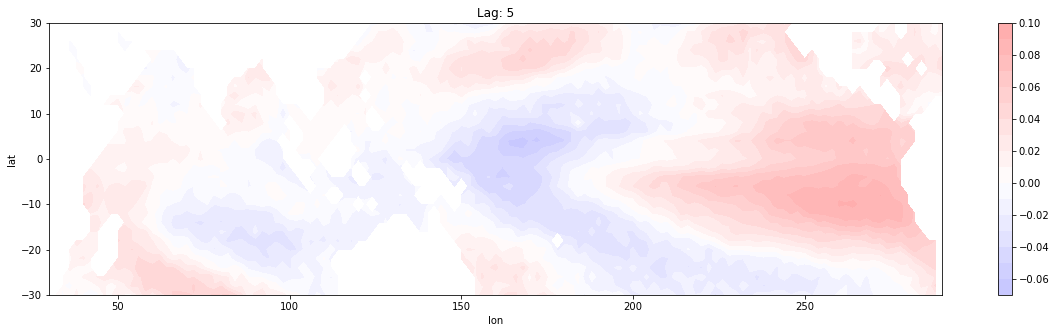

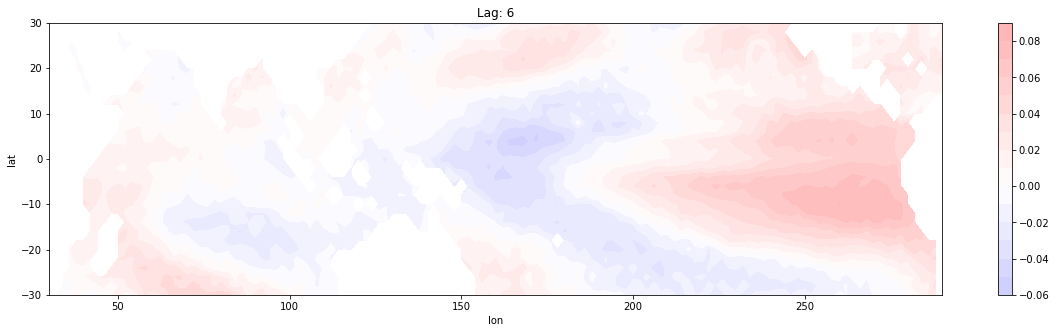

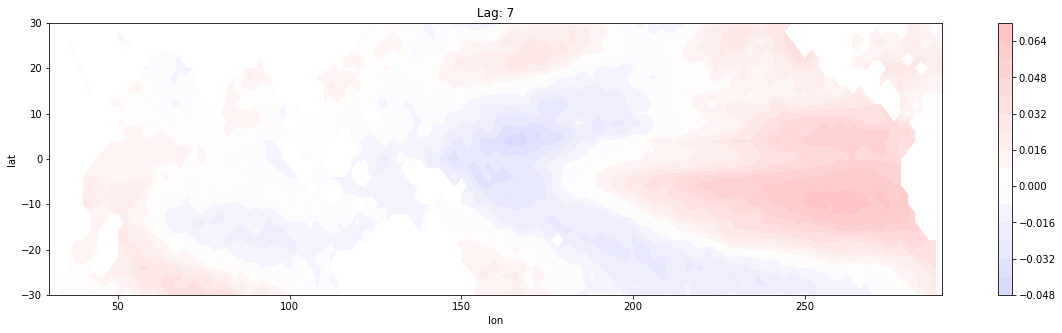

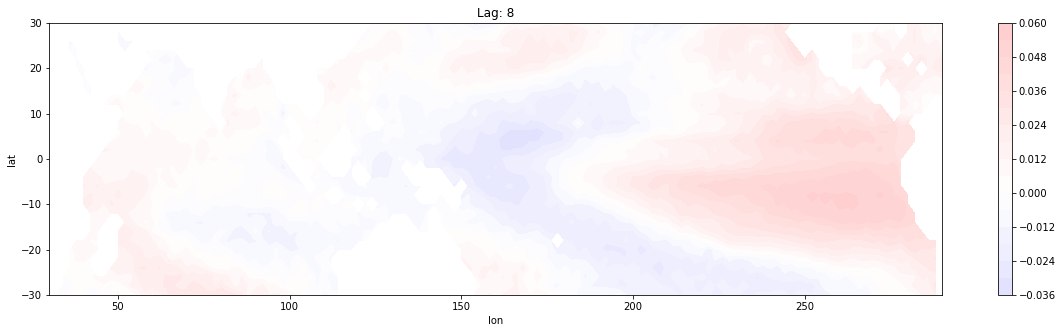

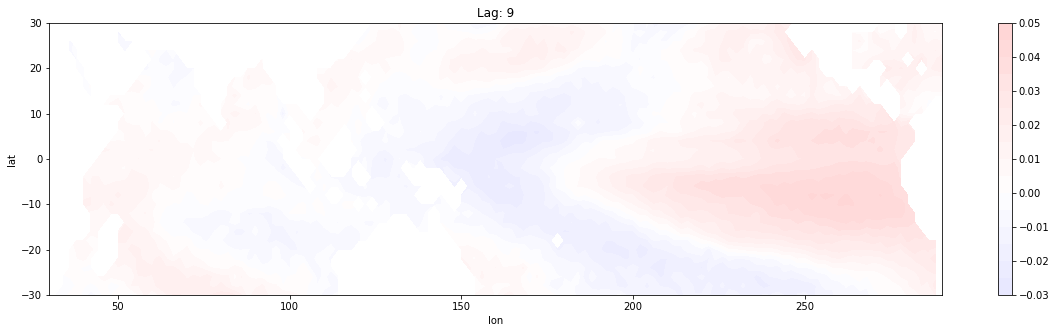

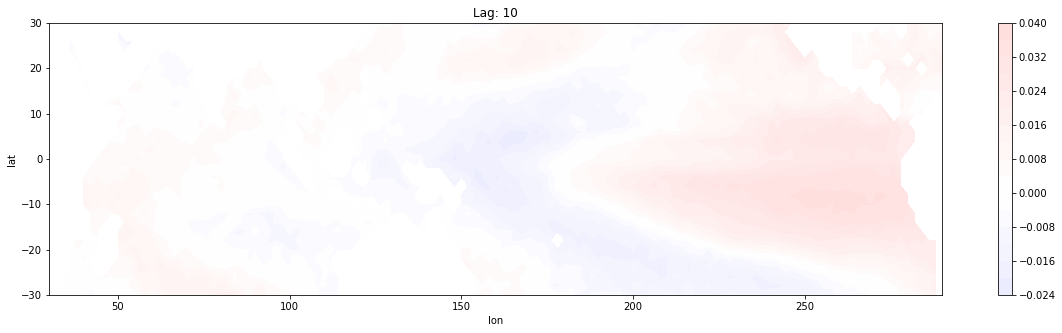

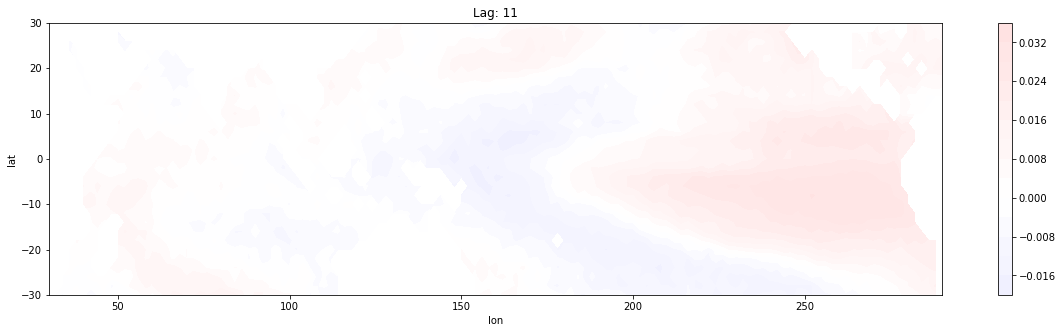

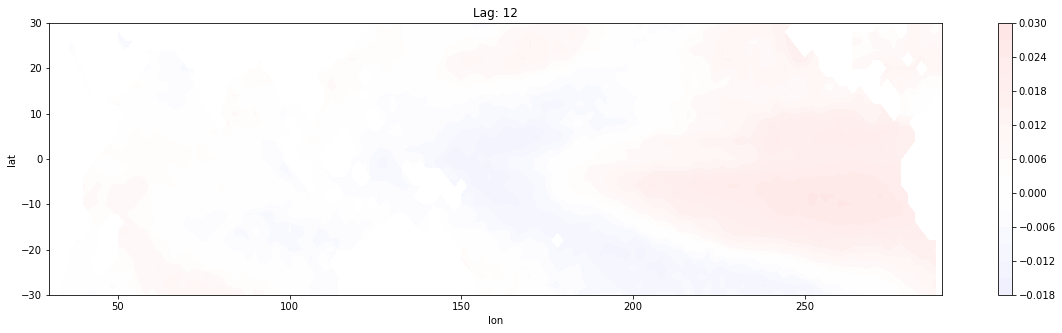

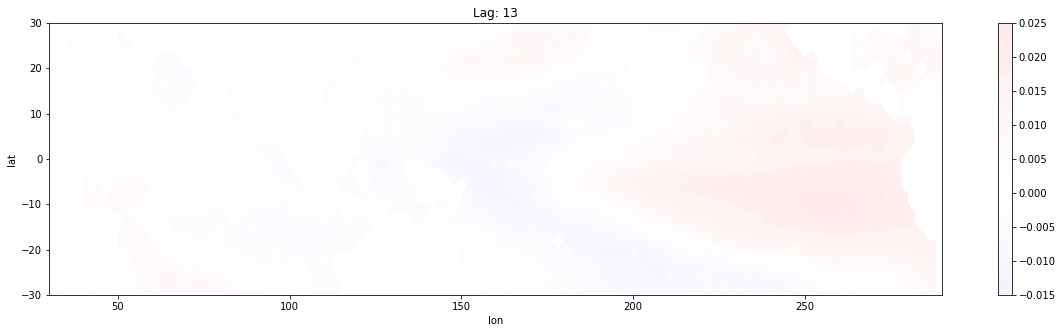

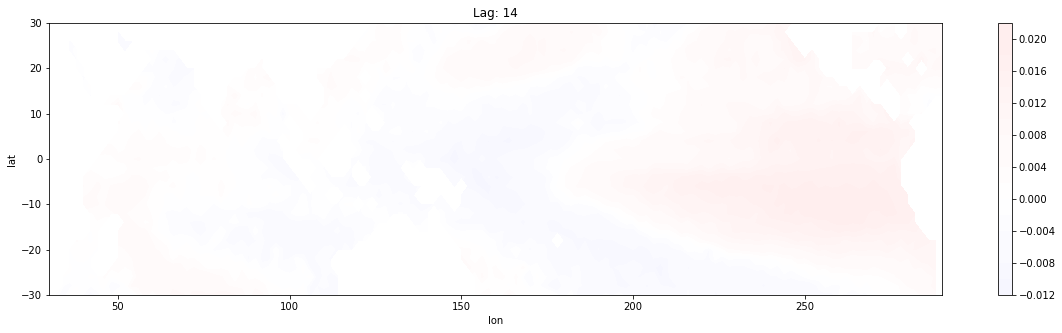

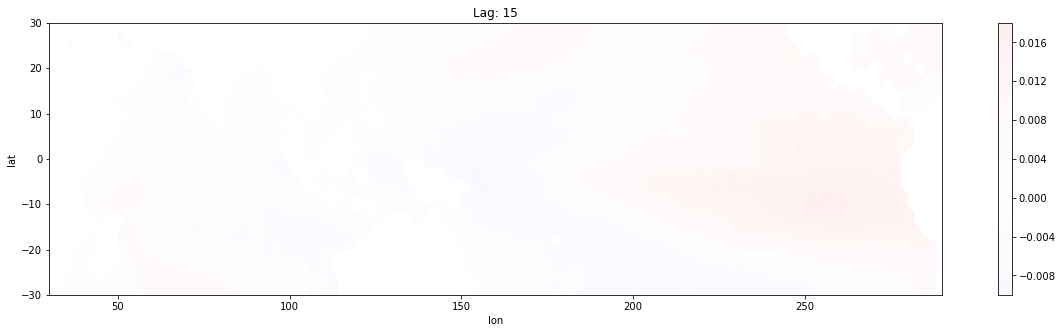

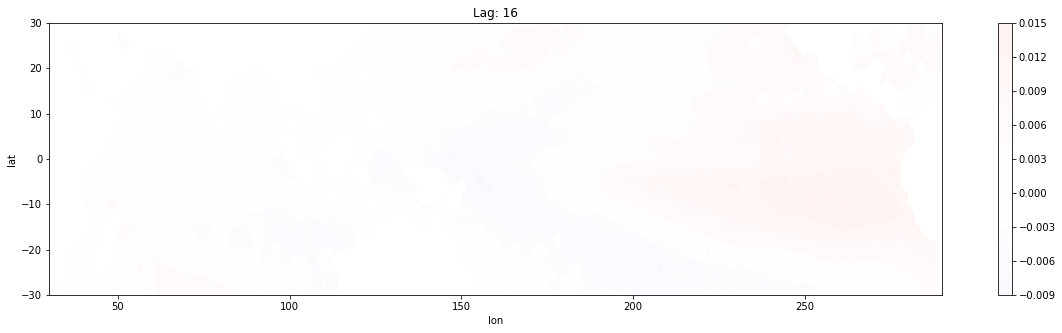

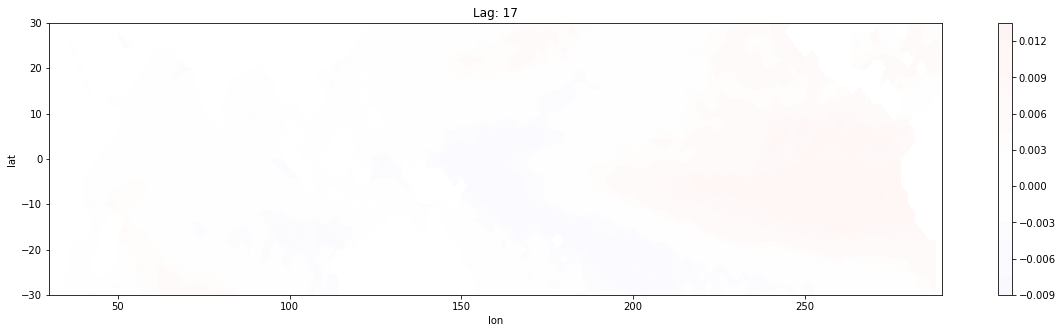

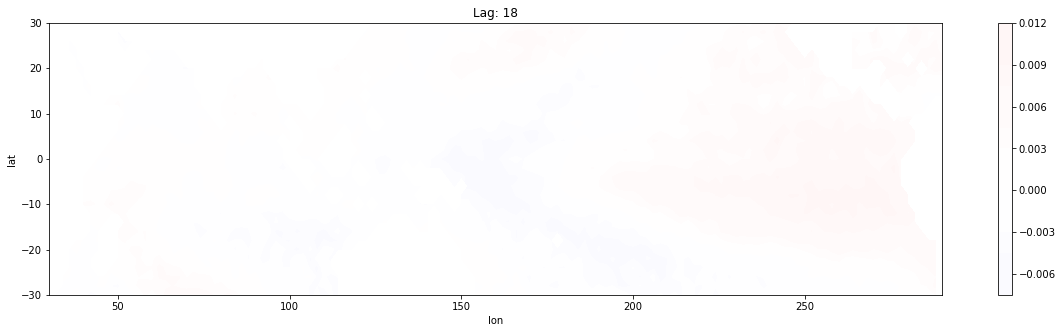

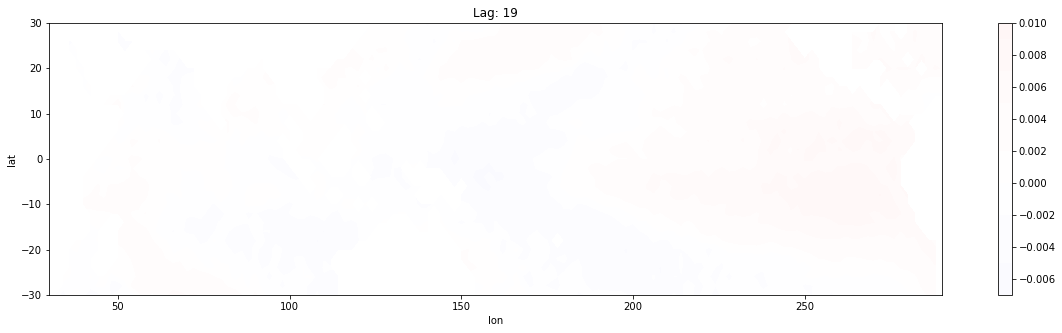

In [253]:
lags = range(1, 20)
skill_e = [
    pcalim.calc_expected_time_avg_spatial_skill(X=df_monthly.values, lag=l)
    for l in lags
]
skill_e = pd.DataFrame(
    data=np.concatenate(skill_e, axis=0), 
    columns=df_monthly.columns, 
    index=lags
)
skill_e.index.name = df_monthly.index.name
detr_copy = df_tfm.inverse_transform(skill_e)
for i, t in enumerate(skill_e.index): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        detr_copy.coords['longitude'], 
        detr_copy.coords['latitude'],
        detr_copy[i, :, :], 
        cmap='bwr', vmin=-0.3, vmax=0.3, levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(f'Lag: {t}')
    plt.show()


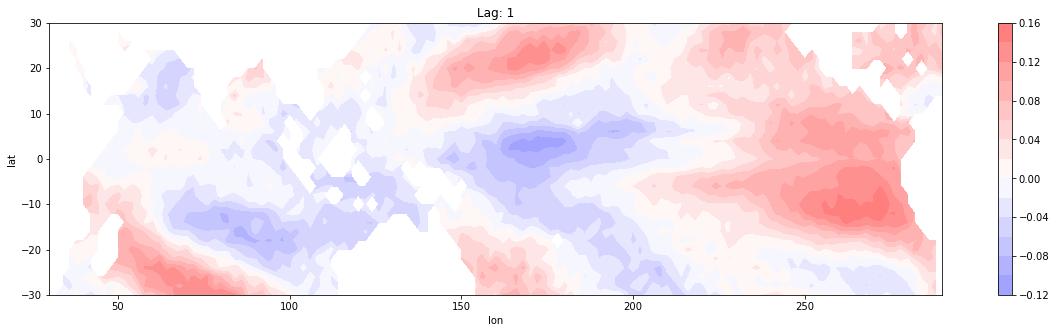

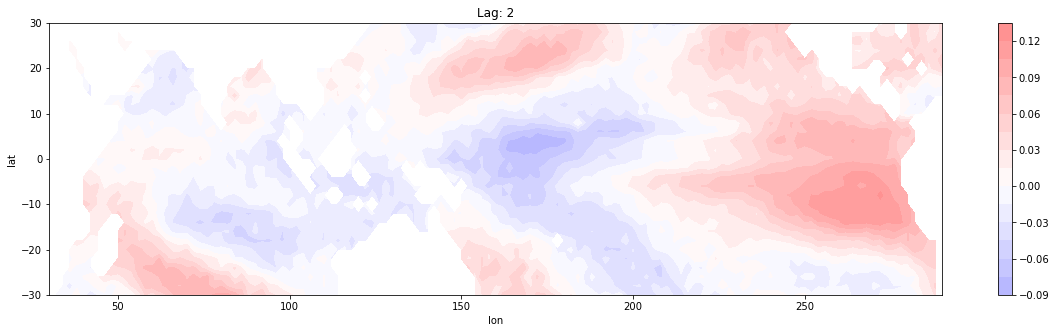

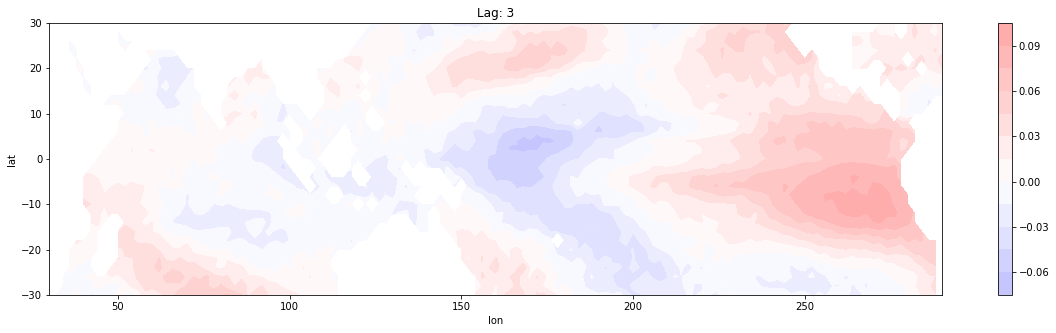

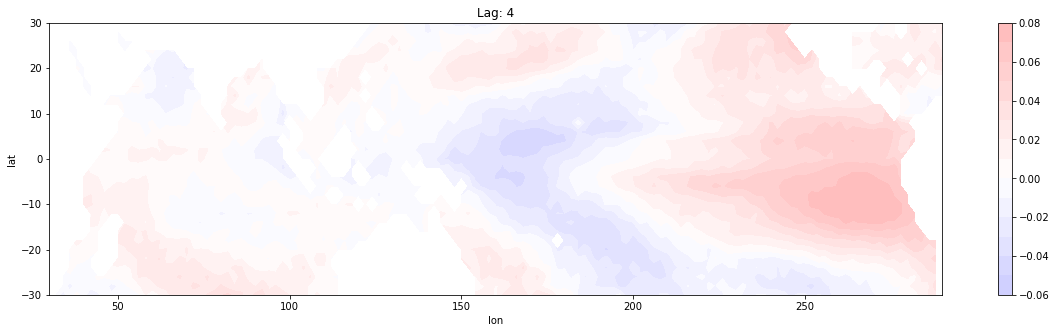

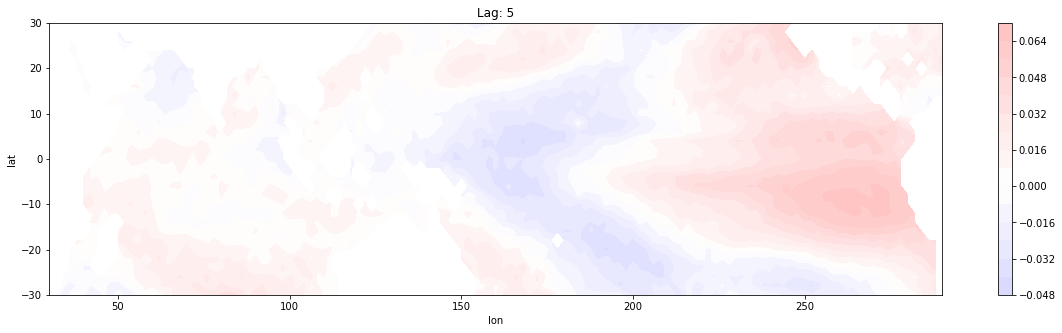

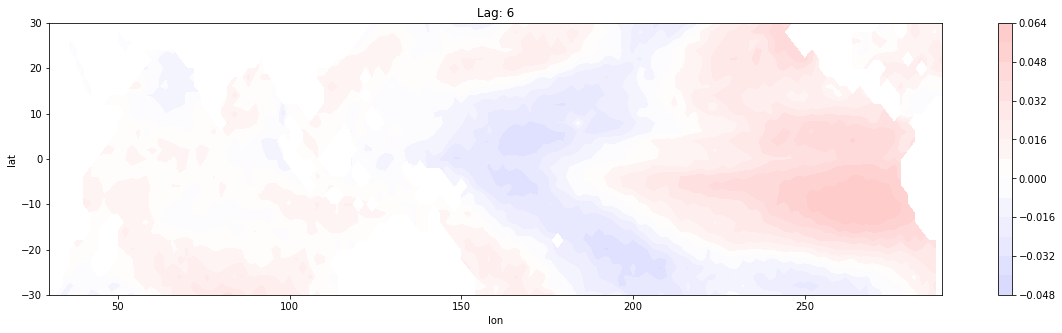

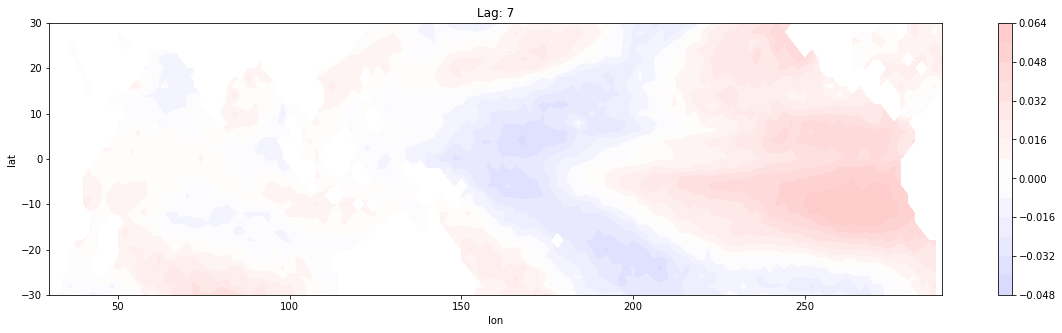

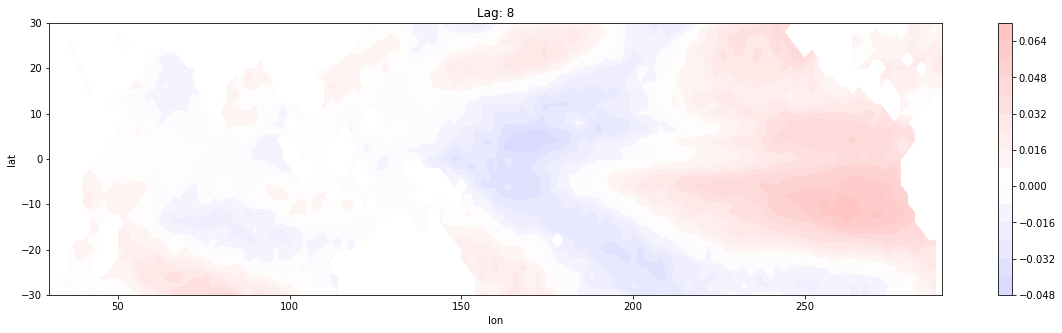

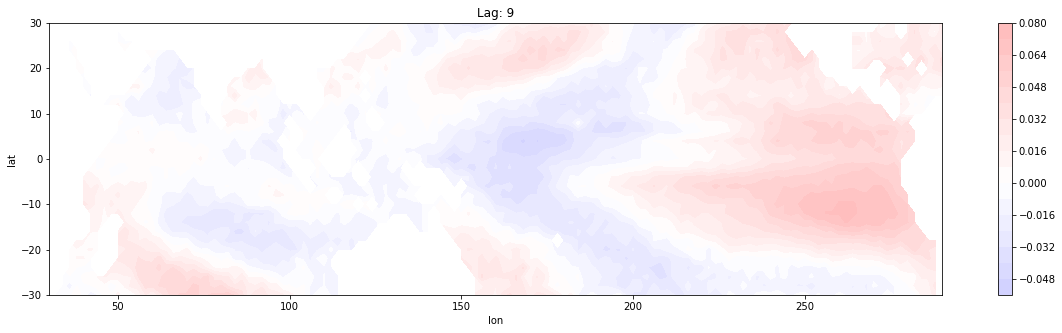

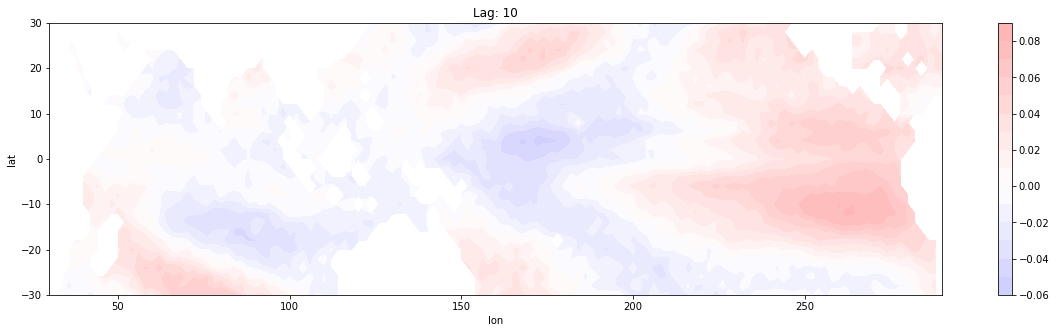

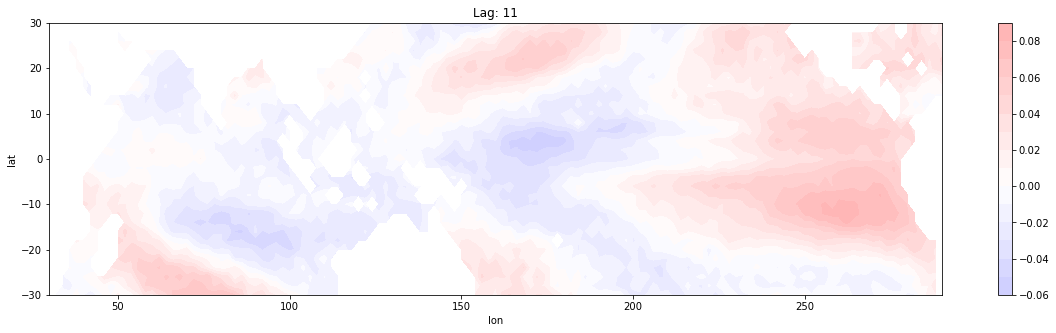

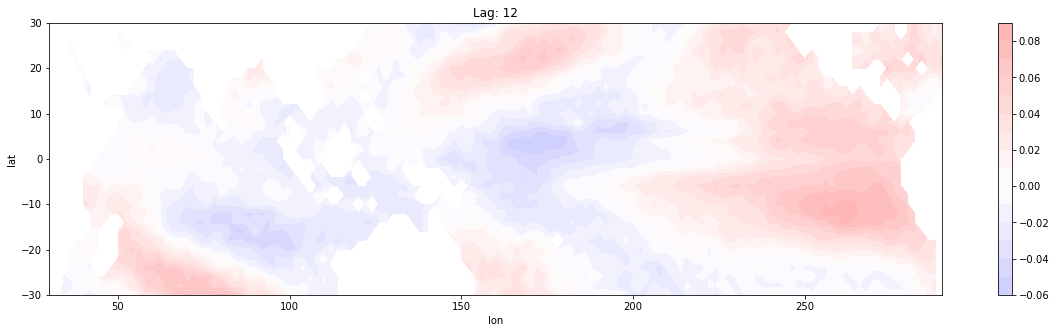

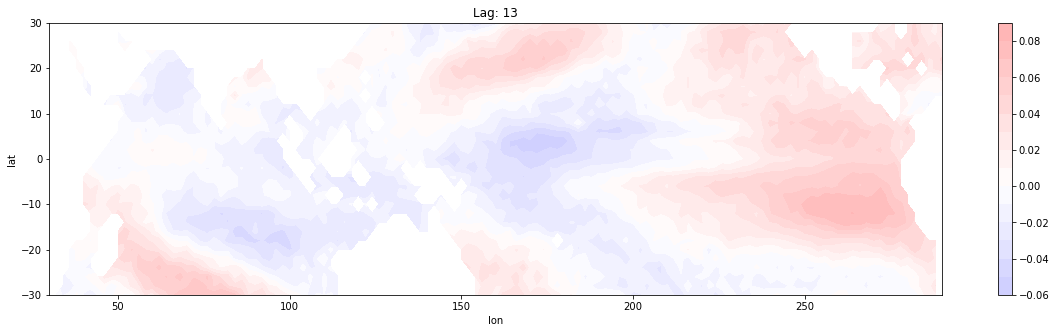

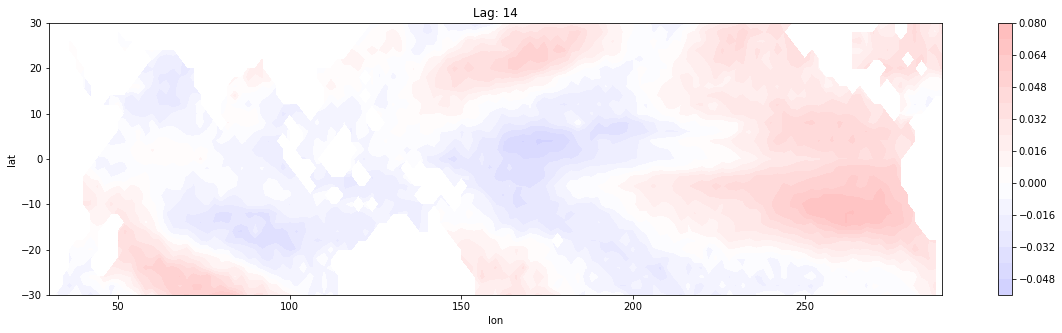

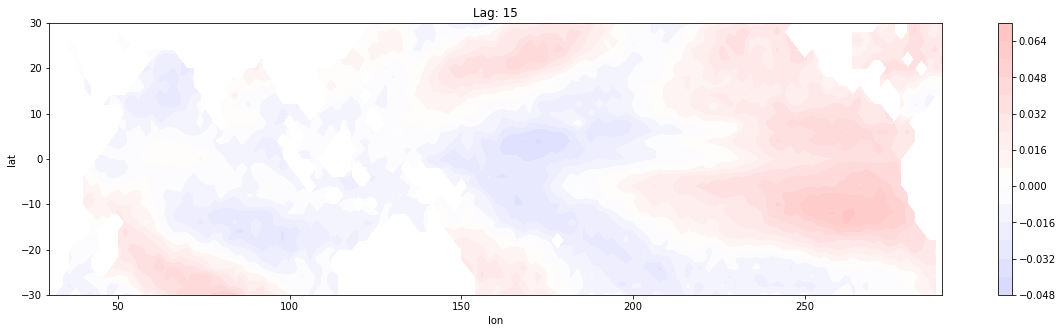

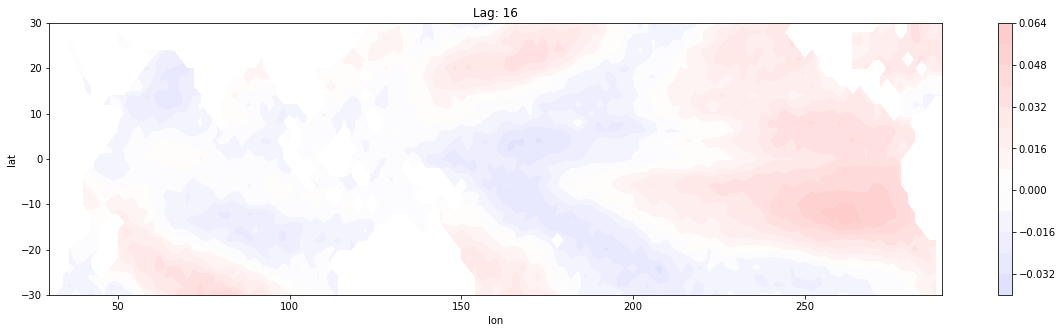

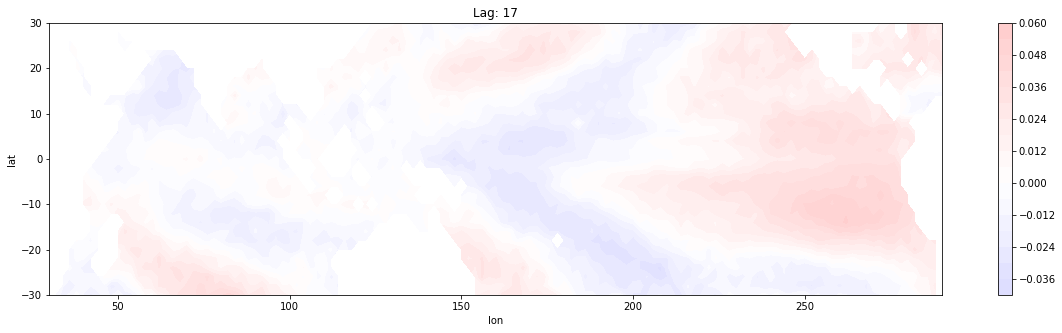

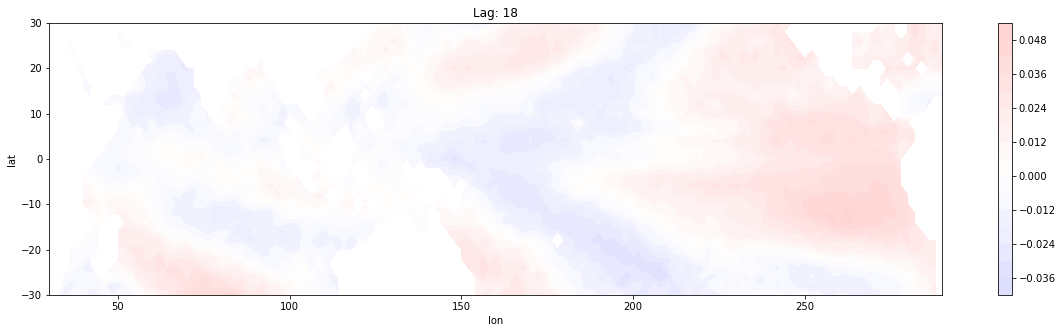

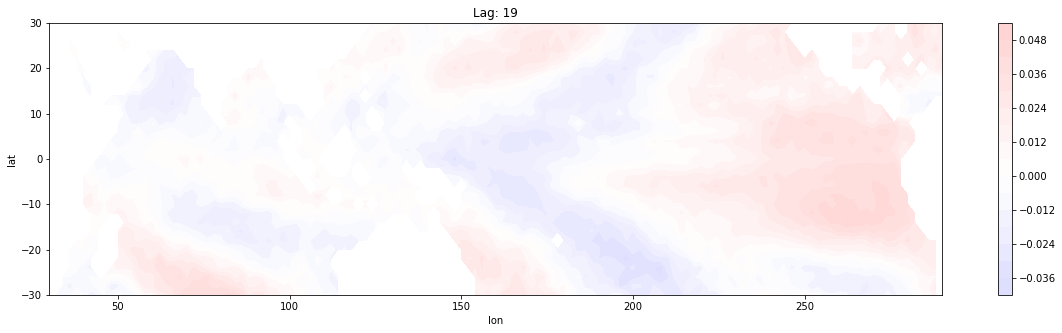

In [145]:
lags = range(1, 20)
skill_r = [
    pcalim.calc_real_time_avg_spatial_skill(X=df_monthly.values, lag=l)
    for l in lags
]
skill_r = pd.DataFrame(
    data=np.concatenate(skill_r, axis=0), 
    columns=df_monthly.columns, 
    index=lags
)
skill_r.index.name = df_monthly.index.name
detr_copy = df_tfm.inverse_transform(skill_r)
for i, t in enumerate(skill_r.index): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        detr_copy.coords['longitude'], 
        detr_copy.coords['latitude'],
        detr_copy[i, :, :], 
        cmap='bwr', vmin=-0.3, vmax=0.3, levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(f'Lag: {t}')
    plt.show()

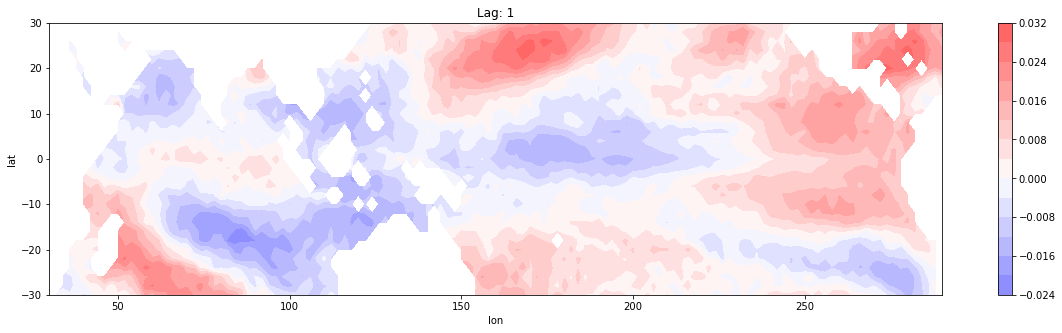

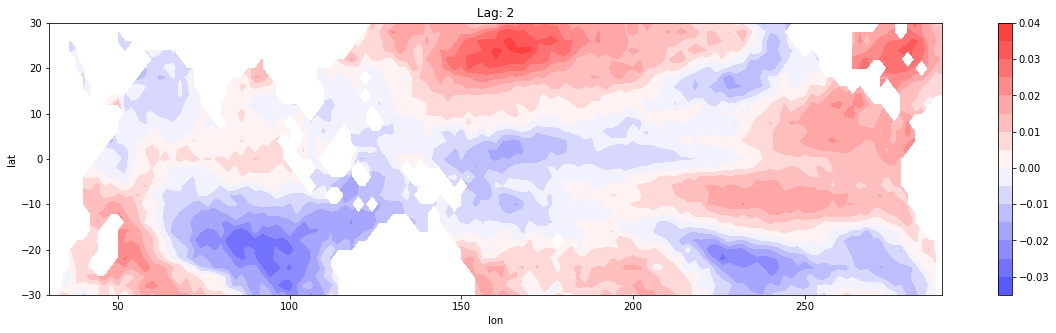

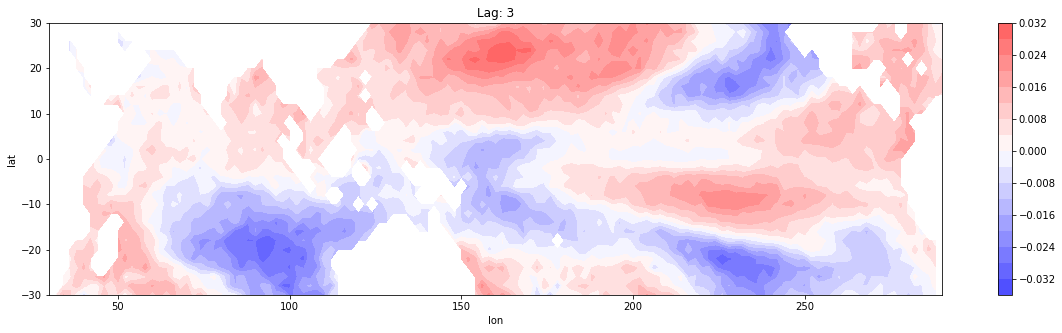

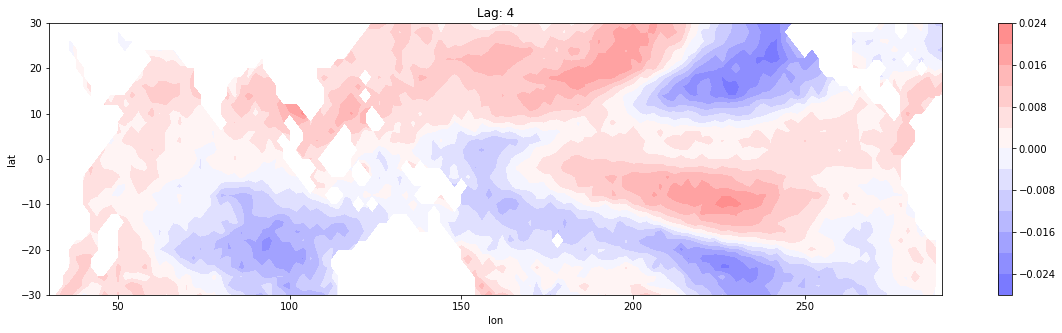

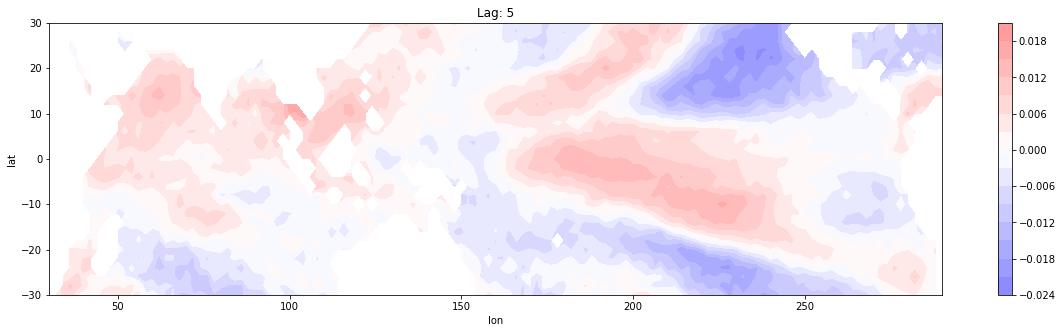

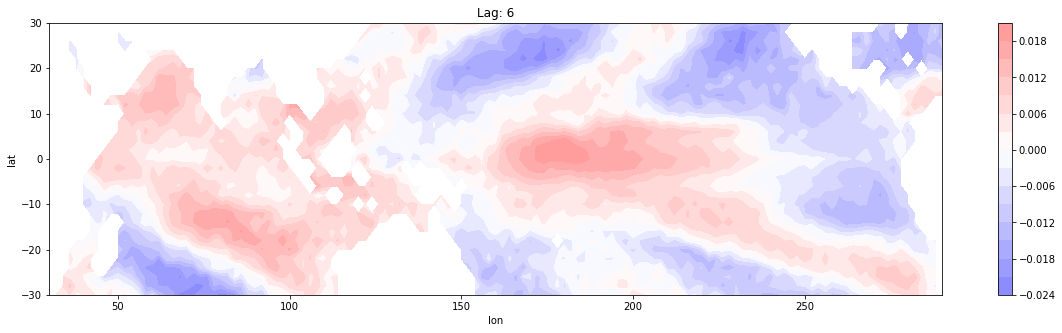

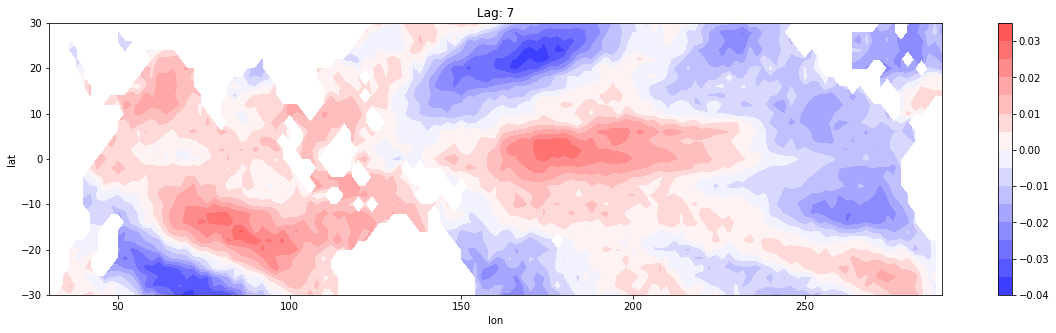

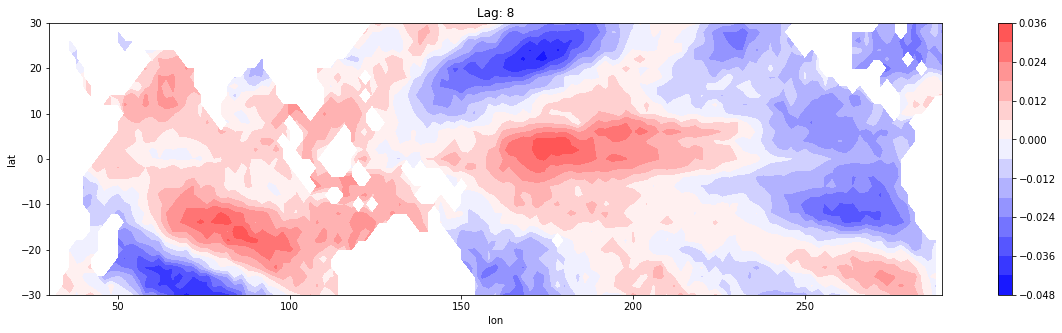

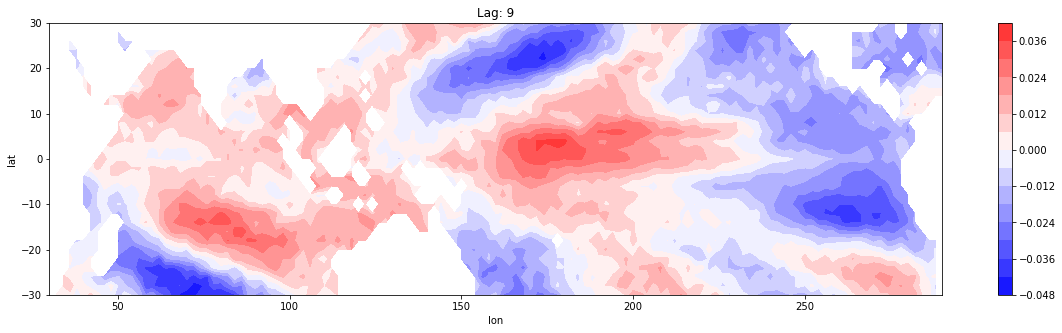

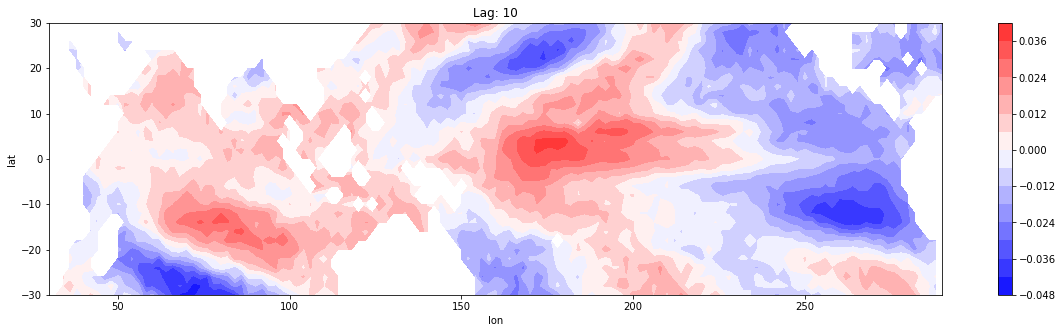

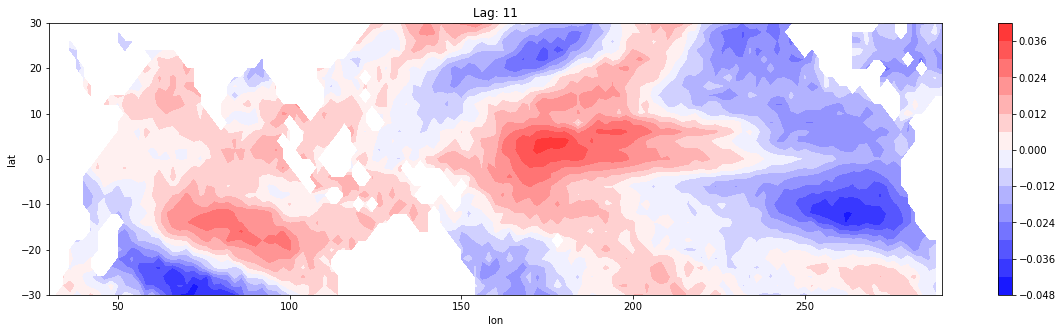

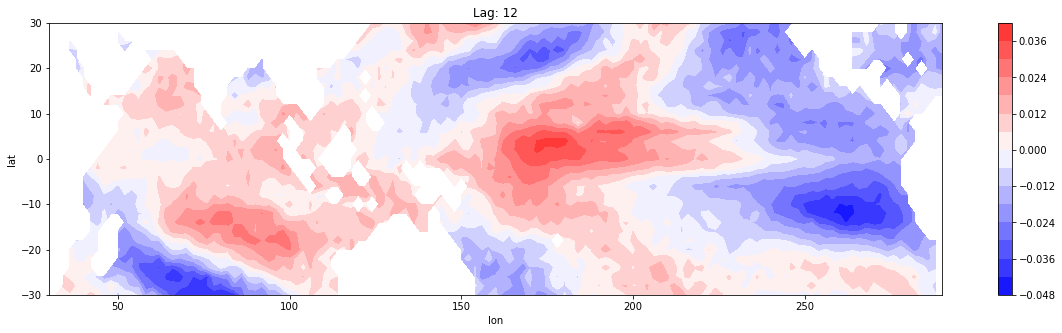

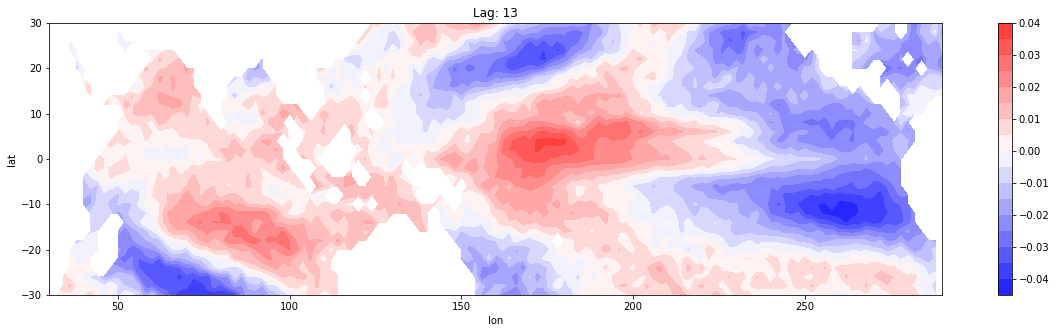

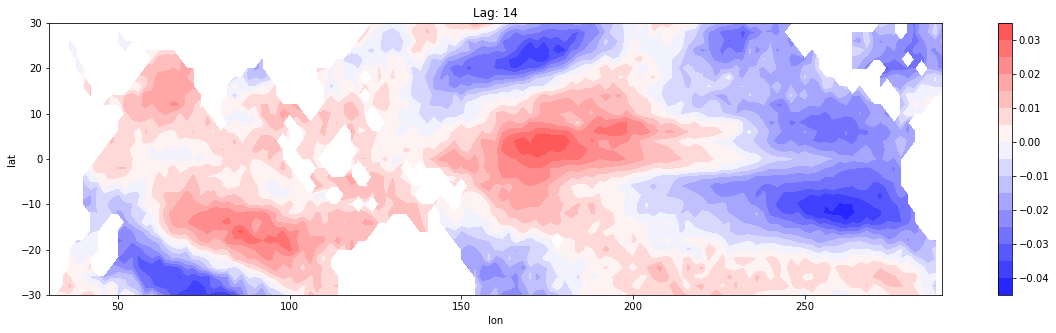

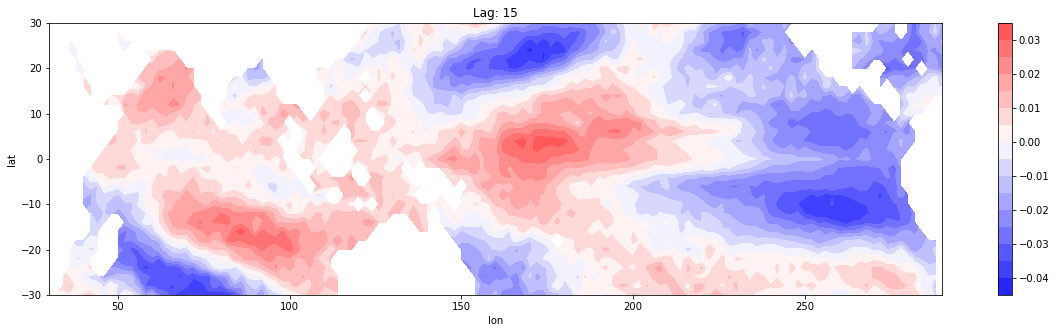

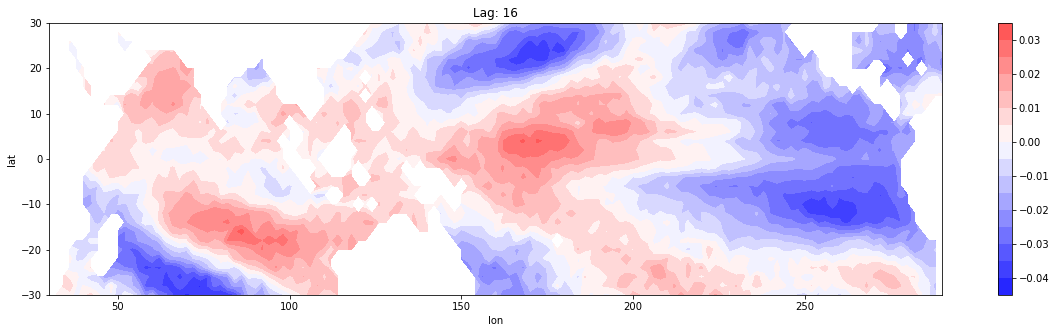

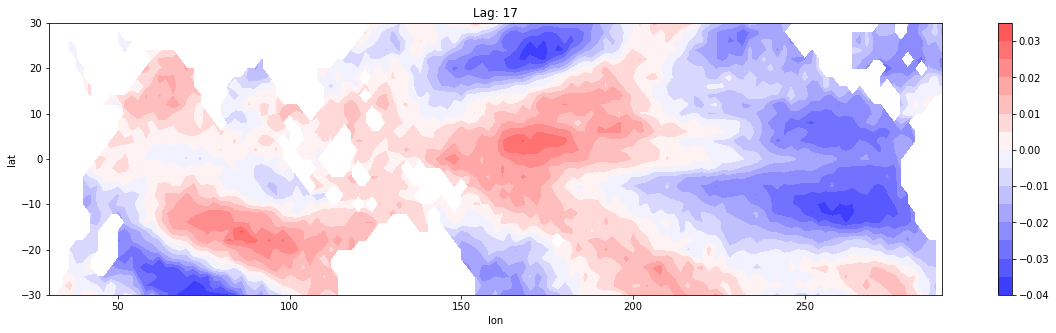

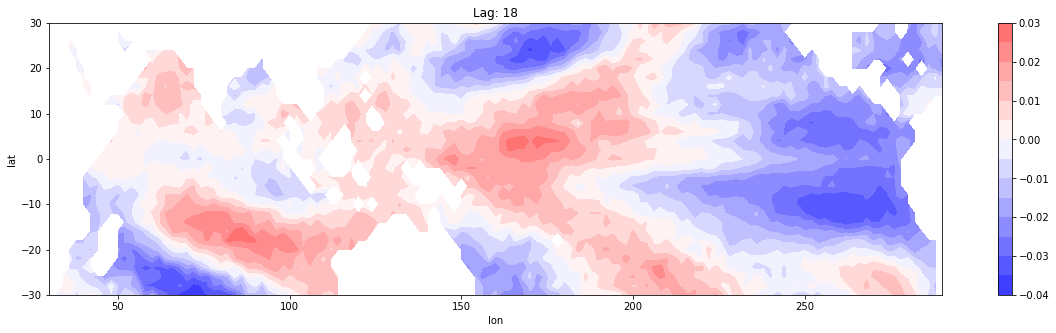

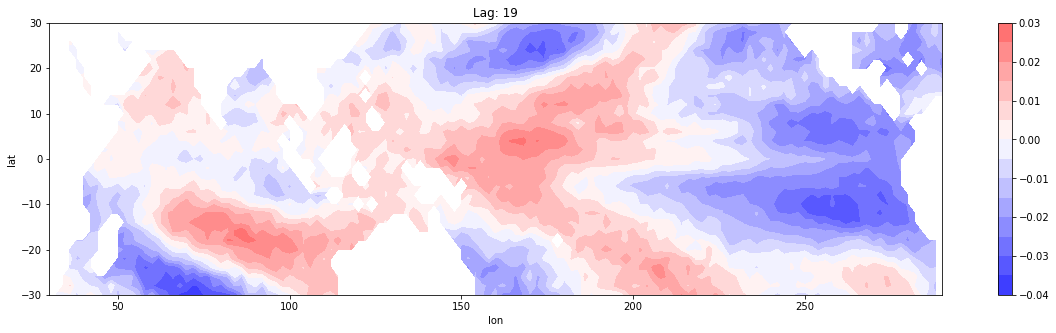

In [141]:
diff = (skill_e - skill_r)
detr_copy = df_tfm.inverse_transform(diff)
for i, t in enumerate(diff.index): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        detr_copy.coords['longitude'], 
        detr_copy.coords['latitude'],
        detr_copy[i, :, :], 
        cmap='bwr', vmin=-0.05, vmax=0.05, levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(f'Lag: {t}')
    plt.show()

/opt/anaconda3/envs/sst_model/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/sst_model/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


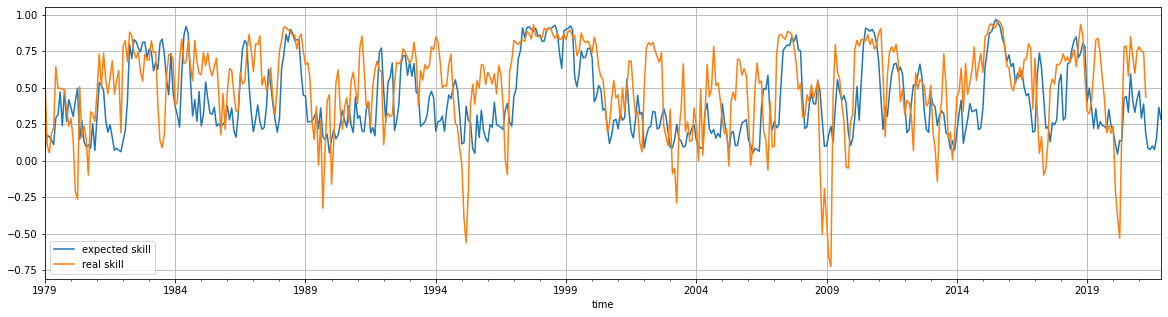

/opt/anaconda3/envs/sst_model/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


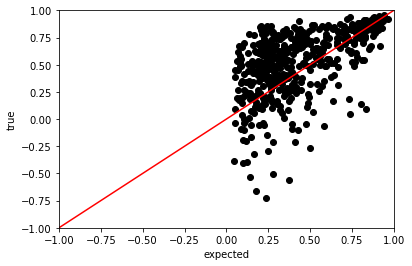

In [254]:
lag = 7
time_skill_e = pd.Series(
    data=pcalim.calc_expected_spatial_avg_time_skill(X=df_monthly.values, lag=lag), 
    index=df_monthly.index
)
time_skill_r = pd.Series(
    data=pcalim.calc_real_spatial_avg_time_skill(X=df_monthly.values, lag=lag), 
    index=df_monthly.index[:-lag]
)

plt.figure(figsize=[20, 5])
time_skill_e.plot(label='expected skill', ax=plt.gca())
time_skill_r.plot(label='real skill', ax=plt.gca())
plt.legend()
plt.grid()
plt.show()

plt.scatter(time_skill_e, time_skill_r.reindex(time_skill_e.index), color='k')
plt.plot([-1, 1], [-1, 1], color='r')
plt.xlabel('expected')
plt.ylabel('true')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

/var/folders/dq/7sw_cxq97gjg6xd_0d3phv_00000gn/T/ipykernel_4544/2143349485.py:366: ComplexWarning: Casting complex values to real discards the imaginary part
  predictability[i, :] = self.predict_expected_spatial_skill_(alpha_i * struct)


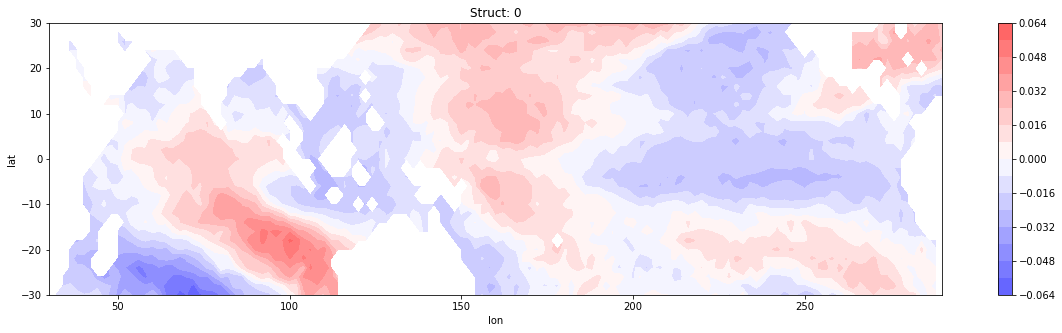

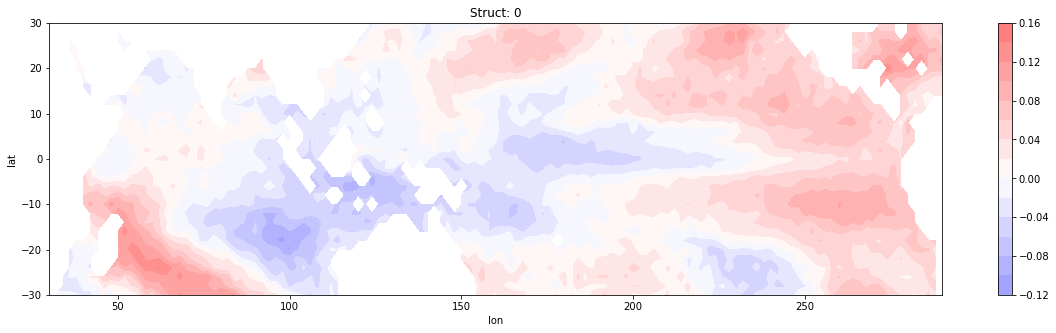

In [329]:
i_struct = 0

struct, pability = pcalim.calc_maximally_amplifying_structures(lag=7)
struct = pd.DataFrame(
    data=struct, 
    columns=df_monthly.columns, 
    index=pd.RangeIndex(struct.shape[0], name=df_monthly.index.name)
)

detr_copy = df_tfm.inverse_transform(struct)
plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr_copy.coords['longitude'], 
    detr_copy.coords['latitude'],
    detr_copy[i_struct, :, :], 
    cmap='bwr', vmin=-0.1, vmax=0.1, levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Struct: {i_struct}')
plt.show()

pability = pd.DataFrame(
    data=pability, 
    columns=df_monthly.columns, 
    index=pd.RangeIndex(struct.shape[0], name=df_monthly.index.name)
)

detr_copy = df_tfm.inverse_transform(pability)
plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr_copy.coords['longitude'], 
    detr_copy.coords['latitude'],
    detr_copy[i_struct, :, :], 
    cmap='bwr', vmin=-0.3, vmax=0.3, levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Struct: {i_struct}')
plt.show()

In [350]:
pcalim.calc_corr_with_maximally_amplifying_structures(x0=df_monthly.iloc[218].values.ravel(), lag=7)

/var/folders/dq/7sw_cxq97gjg6xd_0d3phv_00000gn/T/ipykernel_4544/1166252885.py:366: ComplexWarning: Casting complex values to real discards the imaginary part
  predictability[i, :] = self.predict_expected_spatial_skill_(alpha_i * struct)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 3303)

In [273]:
start = 218
n_steps = 60
lim = LIM().fit(df_decomp.values, fit_periods=1)
sim = pd.DataFrame(
    index=df_decomp.index[start: start + n_steps + 1], 
    columns=df_decomp.columns,
    data=lim.simulate(
        df_decomp.values[start, :], 
        sim_periods=n_steps, 
        steps_per_period=240, 
        with_noise=True
    )
)
sim_itfm = pca.inverse_transform(sim)

sim_itfm.head(10)


latitude        30.0                                                    \
longitude      50.0      124.0     126.0     128.0     130.0     132.0   
time                                                                     
1997-03-01 -0.372561 -0.017954 -0.076818 -0.299207 -0.523701 -0.232658   
1997-04-01 -0.447591  0.059899  0.034986 -0.137179 -0.372827 -0.056791   
1997-05-01 -0.331249 -0.036721 -0.030774 -0.324060 -0.392625 -0.153708   
1997-06-01 -0.178344 -0.251328 -0.278215 -0.497907 -0.608781 -0.474264   
1997-07-01 -0.192833 -0.087612 -0.115616 -0.448888 -0.412983 -0.255078   
1997-08-01 -0.088913  0.096457 -0.268412 -0.520347 -0.381016 -0.342873   
1997-09-01  0.061372 -0.306872 -0.833995 -1.193443 -1.117429 -1.171117   
1997-10-01  0.083467 -0.421954 -0.698368 -1.137369 -1.047382 -1.017230   
1997-11-01  0.075829 -0.274568 -0.307915 -0.891920 -0.816731 -0.657519   
1997-12-01  0.064253  0.103652  0.019070 -0.560987 -0.440215 -0.190334   

latitude                                            ...     -30.0            \
longitude      134.0     136.0     138.0     140.0  ...     270.0     272.0   
time                                                ...                       
1997-03-01 -0.408804 -0.488551 -0.255359 -0.354073  ...  1.597177  1.516700   
1997-04-01  0.018821  0.036650  0.413296  0.292787  ...  1.989674  1.939516   
1997-05-01 -0.127115 -0.087395  0.181872 -0.015693  ...  1.622621  1.568916   
1997-06-01 -0.315051 -0.314639  0.082161 -0.266340  ...  1.734886  1.757905   
1997-07-01 -0.157485  0.023029  0.352177  0.088824  ...  1.569961  1.610507   
1997-08-01 -0.244058 -0.141313  0.027169  0.004495  ...  0.192836  0.405168   
1997-09-01 -0.776125 -0.884001 -0.500879 -0.595781  ... -0.314200 -0.063706   
1997-10-01 -0.678307 -0.730352 -0.404782 -0.630954  ... -0.448369 -0.121720   
1997-11-01 -0.151007 -0.157746  0.307999 -0.094540  ...  0.327070  0.504115   
1997-12-01  0.319649  0.405560  0.944162  0.654799  ...  0.322905  0.453488   

latitude                                                                \
longitude      274.0     276.0     278.0     280.0     282.0     284.0   
time                                                                     
1997-03-01  1.313726  1.344460  1.187086  1.156396  1.134046  0.788112   
1997-04-01  1.741558  1.709675  1.583921  1.688763  1.627995  1.232211   
1997-05-01  1.392961  1.590783  1.576943  1.632165  1.494595  1.172387   
1997-06-01  1.580873  1.704284  1.700127  1.797051  1.602033  1.392846   
1997-07-01  1.498134  1.633072  1.738457  1.896077  1.769901  1.483614   
1997-08-01  0.325786  0.430553  0.430903  0.615599  0.694125  0.601800   
1997-09-01 -0.313502 -0.206383 -0.297647  0.007913  0.049797  0.109066   
1997-10-01 -0.347636 -0.252702 -0.323779  0.123198  0.179792  0.317183   
1997-11-01  0.373611  0.488801  0.569950  1.098262  0.999220  1.075379   
1997-12-01  0.525024  0.562408  0.744726  1.355847  1.342621  1.411725   

latitude                        
longitude      286.0     288.0  
time                            
1997-03-01  1.005601  0.827711  
1997-04-01  1.524424  1.135604  
1997-05-01  1.391678  0.954726  
1997-06-01  1.561423  1.103454  
1997-07-01  1.695543  1.290487  
1997-08-01  0.850652  0.858346  
1997-09-01  0.297773  0.474343  
1997-10-01  0.437857  0.588769  
1997-11-01  1.145873  0.981939  
1997-12-01  1.592644  1.389353  

[10 rows x 3303 columns]

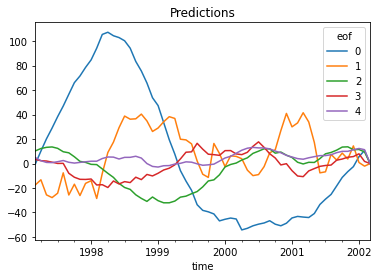

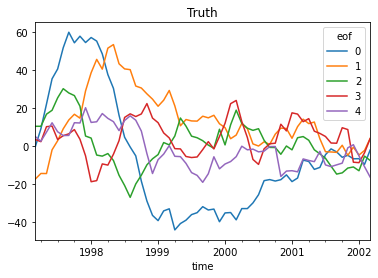

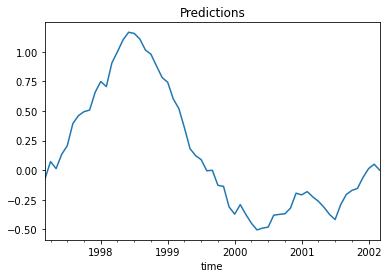

In [274]:
sim.iloc[:, :5].plot()
plt.title('Predictions')
plt.show()

df_decomp.iloc[start: start + n_steps + 1, :5].plot()
plt.title('Truth')
plt.show()

sim_itfm.mean(axis=1).plot()
plt.title('Predictions')
plt.show()


(array([[-3.37836689e-01,  8.39238322e-02,  1.79595289e-01,
         -4.06787318e-01, -3.74479547e-01,  6.05523416e-02,
         -2.13400189e-02,  1.89610274e-01, -5.57339144e-01,
          1.76661794e-01, -1.10101099e-01, -2.69662777e-01,
         -1.39398436e-01,  5.48115378e-02, -2.27312556e-01],
        [ 3.73746973e-01, -7.01252886e-01,  8.12531262e-02,
         -2.08963184e-01, -4.70860303e-02, -5.62124707e-02,
         -2.46085969e-01,  4.05158056e-02, -2.09790853e-01,
         -6.29372573e-02, -2.78045683e-01,  9.41439260e-02,
         -4.06566706e-02, -2.81573739e-01,  1.88760749e-01],
        [-4.00204742e-01, -3.67327389e-01,  1.17242168e-01,
          4.57007599e-02,  5.11737746e-01,  4.59023055e-01,
         -1.32101526e-01, -1.09268309e-01, -1.43391534e-01,
         -9.56842583e-02,  1.10557452e-01, -2.94639541e-02,
         -7.27750258e-02,  3.67571253e-01,  6.23850181e-02],
        [ 1.09081585e-01,  1.16890277e-01, -1.13455770e-01,
         -6.37094887e-01,  3.32191781

In [598]:
df_decomp.iloc[start: start + n_steps + 1, :].round(3)

eof,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
time,,,,,,,,,,,,,,,
1997-02-01,-17.340,-21.904,10.573,4.964,6.402,2.858,10.141,-10.479,-0.366,-11.917,-7.849,-7.591,6.223,-4.142,-6.524
1997-03-01,-0.390,-17.458,10.337,3.354,4.865,8.840,11.220,-18.610,-0.697,-7.890,-9.684,-2.924,11.049,-2.795,3.279
1997-04-01,9.038,-14.518,10.347,2.239,2.496,6.710,6.457,-15.309,-6.357,-5.401,-9.930,-7.790,9.163,-3.926,-2.737
1997-05-01,22.045,-14.560,16.719,10.135,7.253,-3.489,11.310,-8.093,-4.660,-3.268,1.296,-7.203,7.444,-2.696,-4.410
1997-06-01,35.366,-2.064,18.771,10.456,12.187,4.049,16.164,-6.906,4.765,-11.406,0.144,-6.797,-5.024,-11.339,4.222
1997-07-01,40.538,2.725,25.328,3.351,7.453,9.338,15.520,-4.164,9.430,-12.201,5.743,-8.407,1.141,-7.173,4.010
1997-08-01,51.728,9.005,30.152,5.403,5.456,13.859,9.567,5.730,13.722,-2.886,4.439,-6.171,3.317,-5.132,2.145
1997-09-01,59.895,13.660,27.901,6.364,5.522,12.350,12.985,5.077,8.683,-2.298,6.075,-0.530,-6.028,-5.574,-3.017
1997-10-01,54.338,16.677,26.512,8.601,12.212,14.133,8.883,5.562,-1.833,-3.558,7.952,-5.290,-15.208,-3.919,-14.695


## Real LIM (from github)

In [562]:
import numpy as np
from numpy.linalg import pinv, eigvals, eig, eigh


class LIMReal(object):
    """Linear inverse forecast model.
    
    This class uses a calibration dataset to make simple linear forecasts.
    
    Notes
    -----
    Based on the LIM described by M. Newman (2013) [1].  Right now it
    assumes the use of monthly data (i.e. each timestep should represent a
    single month).
    
    References
    ----------
    .. [1] Newman, M. (2013), An Empirical Benchmark for Decadal Forecasts of 
       Global Surface Temperature Anomalies, J. Clim., 26(14), 5260–5269, 
       doi:10.1175/JCLI-D-12-00590.1.
    ....
    """

    def __init__(self, tau0_data, tau1_data=None, nelem_in_tau1=1,
                 fit_noise=False, max_neg_Qeval=5, h5file=None):
        """
        Parameters
        ----------
        tau0_data: ndarray
            Data for calibrating the LIM.  Expects
            a 2D MxN matrix where M (rows) represent the sampling dimension and
            N(columns) represents the feature dimension (e.g. spatial grid
            points).
        tau1_data: ndarray, optional
            Data with lag of tau=1.  Used to calculate the mapping term, G1,
            going from tau0 to tau1.  Must be the same shape as tau0_data.  If
            not provided, tau0_data is assumed to be sequential and
            nelem_in_tau1 and tau0_data is used to calculate lag covariance.
        nelem_in_tau1: int, optional
            Number of time samples that span tau=1.  E.g. for monthly data when
            a forecast tau is equivalent to 1 year, nelem_in_tau should be 12.
            Used if tau1_data is not provided.
        fit_noise: bool, optional
            Whether to fit the noise term from calibration data. Used for
            noise integration
        max_neg_Qeval: int, optional
            The maximum number of allowed negative eigenvalues in the Q matrix.
            Negative eigenvalues suggest inclusion of too many modes, but a few
            spurious ones are common.  I've been using a max of 5, but this
            isn't based on an objective knowledge.
        h5file: HDF5_Object, Optional
            File object to store LIM output.  It will create a series of
            directories under the given group
        """

        if tau0_data.ndim != 2:
            raise ValueError('Input LIM calibration data is not 2D')

        self._h5file = h5file
        self._from_precalib = False
        self._nelem_in_tau1 = nelem_in_tau1
        self._eof_var_stats = {}

        if tau1_data is not None:
            if not tau1_data.shape == tau0_data.shape:
                raise ValueError('Tau1 and Tau0 calibration data shape '
                                 'mismatch')

            x0 = tau0_data
            x1 = tau1_data
        else:
            x0 = tau0_data[0:-nelem_in_tau1, :]
            x1 = tau0_data[nelem_in_tau1:, :]

        self.G_1 = self._calc_m(x0, x1, tau=1)

        if fit_noise:
            q_res = self._calc_Q(self.G_1, x0, tau=1,
                                 max_neg_evals=max_neg_Qeval)
            [self.L,
             self.Q_evals,
             self.Q_evects,
             self.num_neg_Q,
             self.neg_Q_rescale_factor] = q_res
        else:
            self.L = None
            self.Q_evals = None
            self.Q_evects = None
            self.num_neg_Q = None
            self.neg_Q_rescale_factor = None

    @staticmethod
    def _calc_m(x0, xt, tau=1):
        """Calculate either L or G for forecasting (using nomenclature
        from Newman 2013
        Parameters
        ----------
        x0: ndarray
            State at time=0.  MxN where M is number of samples, and N is the 
            number of features.
        xt: ndarray
            State at time=tau.  MxN where M is number of samples, and N is the 
            number of fatures.
        tau: float
            lag time (in units of tau) that we are calculating G for.  This is 
            used to check that all modes of L are damped.
        """

        # These represent the C(tau) and C(0) covariance matrices
        #    Note: x is an anomaly vector, no division by N-1 because it's undone
        #    in the inversion anyways

        # Division by number of samples ignored due to inverse
        x0x0 = np.dot(x0.T, x0)
        x0xt = np.dot(xt.T, x0)

        # Calculate the mapping term G_tau
        G = np.dot(x0xt, pinv(x0x0))

        # Calculate the forcing matrix to check that all modes are damped
        Geigs = eigvals(G)
        Leigs = (1. / tau) * np.log(Geigs)

        if np.any(Leigs.real >= 0):
            raise ValueError(
                'Positive eigenvalues detected in forecast matrix L.')

        return G

    @staticmethod
    def _calc_Q(G, x0, tau=1, max_neg_evals=5):
        C0 = x0.T @ x0 / (x0.shape[0] - 1)  # State covariance
        G_eval, G_evects = eig(G)
        L_evals = (1/tau) * np.log(G_eval)
        L = G_evects @ np.diag(L_evals) @ pinv(G_evects)
        L = np.matrix(L)
        # L = L.real
        Q = -(L @ C0 + C0 @ L.H)  # Noise covariance

        # Check if Q is Hermetian
        is_adj = abs(Q - Q.H)
        tol = 1e-10
        if np.any(abs(is_adj) > tol):
            raise ValueError('Determined Q is not Hermetian (complex '
                             'conjugate transpose is equivalent.)')

        q_evals, q_evects = eigh(Q)
        sort_idx = q_evals.argsort()
        q_evals = q_evals[sort_idx][::-1]
        q_evects = q_evects[:, sort_idx][:, ::-1]
        num_neg = (q_evals < 0).sum()

        if num_neg > 0:
            num_left = len(q_evals) - num_neg
            if num_neg > max_neg_evals:
                raise ValueError('More than {:d} negative eigenvalues of Q '
                                 'detected.  Consider further dimensional '
                                 'reduction.'.format(max_neg_evals))

            else:
                pos_q_evals = q_evals[q_evals > 0]
                scale_factor = q_evals.sum() / pos_q_evals.sum()

                q_evals = q_evals[:-num_neg]*scale_factor
                q_evects = q_evects[:, :-num_neg]
        else:
            scale_factor = None

        # Change back to arrays
        L = np.array(L)
        q_evects = np.array(q_evects)

        return L, q_evals, q_evects, num_neg, scale_factor

    def forecast(self, t0_data, fcast_leads, use_h5=True):
        """Forecast on provided data.
        
        Performs LIM forecast over the times specified by the
        fcast_times class attribute.  Forecast can be performed by calculating
        G for each time period or by L for a 1-year(or window_size) lag and
        then calculating each fcast_Time G from that L matrix.
        
        Parameters
        ----------
        t0_data: ndarray
            Data to forecast from.  Expects
            a 2D MxN matrix where M (rows) represent the sampling dimension and
            N(columns) represents the feature dimension (e.g. spatial grid
            points).
        fcast_leads: List<int>
            A list of forecast lead times.  Each value is interpreted as a
            tau value, for which the forecast matrix is determined as G_1^tau.
        use_h5: bool
            Use H5file to store forecast data instead of an ndarray.
            
        Returns
        -----
        fcast_out: ndarray-like
            LIM forecasts in a KxJxM^ matrix where K corresponds to each
            forecast time.
        """

        if t0_data.ndim != 2:
            raise ValueError('Input LIM forecast data is not 2D')

        num_fcast_times = len(fcast_leads)

        # Create output locations for our forecasts
        fcast_out_shp = (num_fcast_times, t0_data.shape[0], t0_data.shape[1])
        fcast_out = np.zeros(fcast_out_shp)

        for i, tau in enumerate(fcast_leads):
            g = np.linalg.matrix_power(self.G_1, tau)
            xf = np.dot(g, t0_data.T)
            if use_h5:
                fcast_out[i][:] = xf.T
            else:
                fcast_out[i] = xf.T

        return fcast_out

    def noise_integration(self, t0_data, length, timesteps=1440,
                          out_arr=None, length_out_arr=None,
                          seed=None):
        """Perform a stochastic noise forced integration.
        Performs LIM forecast over the times specified by the
        fcast_times class attribute.  Forecast can be performed by calculating
        G for each time period or by L for a 1-year(or window_size) lag and
        then calculating each fcast_Time G from that L matrix.
        Parameters
        ----------
        t0_data: ndarray
            Initialization data for the stochastic integration.  Expects
            a 2D MxN matrix where M (rows) represent the ensemble dimension and
            N(columns) represents the feature dimension (e.g. spatial grid
            points).  The integration will produce a randomly forced trajectory
            for each ensemble member.
        length: int
            Length (in units of the calibration lag, tau) of the noise
            integration
        timesteps: int
            Number of timesteps in a single length-tau segment of the noise
            integration.  This parameter sets the deltaT for the timestepper.
            E.g., for tau=1-year, 1440 timesteps is ~6hr timestep.
        out_arr: Optional, ndarray
            Optional output container for data at the resolution of deltaT.
            Expected dimensions of (timesteps * length + 1) x N
        length_out_arr: Optional, ndarray
            Optianal output container for data at the resolution of tau.
            Expected dimensions of length x N
        seed: Optional, int
            Seed for the random number generator to perform a reproducible
            stochastic forecast
        Returns
        -----
        ndarray
            Final state of the LIM noise integration forecast. Same dimension
            as input t0_data.
        """

        if seed is not None:
            np.random.seed(seed)

        # t0_data comes in as sample x spatial
        L = self.L
        Q_eval = self.Q_evals[:, None]
        Q_evec = self.Q_evects
        tdelta = 1/timesteps
        integration_steps = int(timesteps * length)
        num_evals = Q_eval.shape[0]
        nens = t0_data.shape[0]

        state_1 = t0_data.T
        state_mid = state_1

        if out_arr is not None:
            out_arr[0] = t0_data

        # Perform noise integration
        for i in range(integration_steps):
            deterministic = (L @ state_1) * tdelta
            random = np.random.normal(size=(num_evals, nens))
            stochastic = Q_evec @ (np.sqrt(Q_eval * tdelta) * random)
            state_2 = state_1 + deterministic + stochastic
            state_mid = (state_1 + state_2) / 2
            state_1 = state_2

            if length_out_arr is not None and i % timesteps == 0:
                len_out_arr_idx = i // timesteps + 1
                out_arr[len_out_arr_idx, :] = state_mid.T

        return state_mid.T.real, out_arr

In [585]:
lim_real = LIMReal(df_decomp.values, fit_noise=True)
# sim2 = lim_real.forecast(df_decomp.values[start:start+1, :], fcast_leads=np.arange(0, n_steps + 1))
_, sim2 = lim_real.noise_integration(df_decomp.values[start:start+1, :], length=n_steps, timesteps=1440, out_arr=np.zeros((n_steps + 1, n_components)), length_out_arr=n_steps+1)

sim2 = pd.DataFrame(
    index=df_decomp.index[start: start + n_steps + 1], 
    columns=df_decomp.columns,
    data=sim2.squeeze()
)

/var/folders/dq/7sw_cxq97gjg6xd_0d3phv_00000gn/T/ipykernel_16343/950491759.py:290: ComplexWarning: Casting complex values to real discards the imaginary part
  out_arr[len_out_arr_idx, :] = state_mid.T


<AxesSubplot:xlabel='time'>

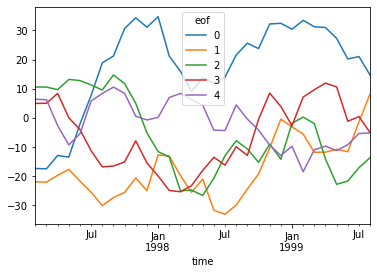

In [586]:
sim2.iloc[:, :5].plot()

<AxesSubplot:xlabel='time'>

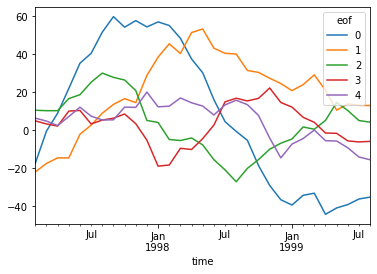

In [583]:
df_decomp.iloc[start: start + n_steps + 1, :5].plot()

In [584]:
lim_real.L - lim.B

array([[ 1.59741357e-04+7.64828875e-17j, -2.88387714e-03-3.10273328e-16j,
         2.24443838e-03+1.39634800e-17j,  3.73602526e-03-1.96563238e-16j,
        -5.60034758e-04-1.31502850e-17j,  4.16391373e-03+7.22709972e-17j,
        -8.76196877e-03+1.67266538e-16j, -6.08950662e-03-1.67806775e-16j,
        -2.64463111e-03-6.73945818e-18j, -5.17931367e-03+1.07698304e-16j,
        -4.55238888e-03+5.17331324e-17j, -2.50125522e-03-1.27933961e-16j,
        -6.62209834e-03+1.07098301e-17j, -7.10262422e-03-4.37338474e-17j,
        -1.17419897e-02+2.28338452e-17j],
       [-9.83281391e-04+1.68375271e-16j, -6.03425071e-04-1.62887688e-16j,
        -1.04297319e-03-4.61699725e-17j, -1.75339036e-03-1.28952381e-16j,
         2.55605138e-04+6.31629085e-17j, -1.93872333e-03-8.72959557e-17j,
         4.08347210e-03+1.81058898e-16j,  2.85542198e-03+3.31233702e-17j,
         1.23343023e-03-3.51452085e-17j,  2.44058686e-03-7.73741546e-17j,
         2.13300139e-03+8.55391695e-17j,  1.18407482e-03-8.14117674e-1

In [451]:
lim.G

array([[ 9.67026492e-01,  9.20321374e-02, -1.90400268e-01,
         2.52390059e-02,  1.75757236e-02, -7.68471131e-02,
        -4.50628257e-02,  1.51886353e-01,  6.81488325e-02,
        -1.15250827e-01, -5.41289068e-02,  1.25386750e-01,
        -2.24097725e-03, -3.58794536e-02, -1.36385969e-01],
       [-4.32595778e-02,  9.19065919e-01, -2.96164165e-02,
         5.99379658e-02,  6.49195018e-02, -5.70335978e-02,
        -2.00899764e-02, -2.15669823e-02,  3.24800569e-02,
        -5.05808690e-02,  6.03050824e-02,  1.29514350e-01,
         2.75263038e-02,  3.17165947e-02, -6.89118028e-02],
       [ 4.65441261e-02,  4.73899655e-02,  8.83720516e-01,
        -4.70492010e-02, -3.47028757e-03, -5.11797315e-03,
         3.27024748e-03, -5.05310206e-02,  2.95796601e-02,
        -6.85064603e-02,  4.25195879e-02,  3.55061896e-02,
        -2.40837042e-01,  3.47669524e-02,  3.28073261e-02],
       [-7.71467429e-03, -2.20350941e-02,  1.68623672e-02,
         8.66823088e-01,  4.52548231e-03,  4.14547075